# **1. SpanBERT/spanbert-base-cased**

1- baseline

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/215M [00:00<?, ?B/s]


STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.261
  Entropy: 0.999
  Top2 ratio: 0.997
  Prob gap: 0.001

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.134
  Entropy: 0.999
  Top2 ratio: 0.997
  Prob gap: 0.000

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.061
  Entropy: 0.999
  Top2 ratio: 0.980
  Prob gap: 0.001

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.480
  Validation F1 (Ambiguous): 0.6829

Random Forest:
  Best Threshold: 0.378
  Validation F1 (Ambiguous): 0.6222

SVM (Linear Kernel):
  Best Threshold: 0.426
  Validation F1 (Ambiguous): 0.5926

Naive Bayes:
  Best Threshold: 0.481
  Validation F1 (Ambiguous): 0.7000

KNN (k=5):
  Best Threshold: 0.000
  Validation F1 (Ambiguous): 0.5926

Gradient Boosting:
  Best Threshold: 0.232
  Validation F1 (Ambiguous): 0.6222

AdaBoost:
  Best Threshold: 0.499
  Validation F1 (Ambiguous): 0.6452

Selected Model: Naive Bayes
Optimized Threshold: 0.481

STEP 3: Final Test Evaluation


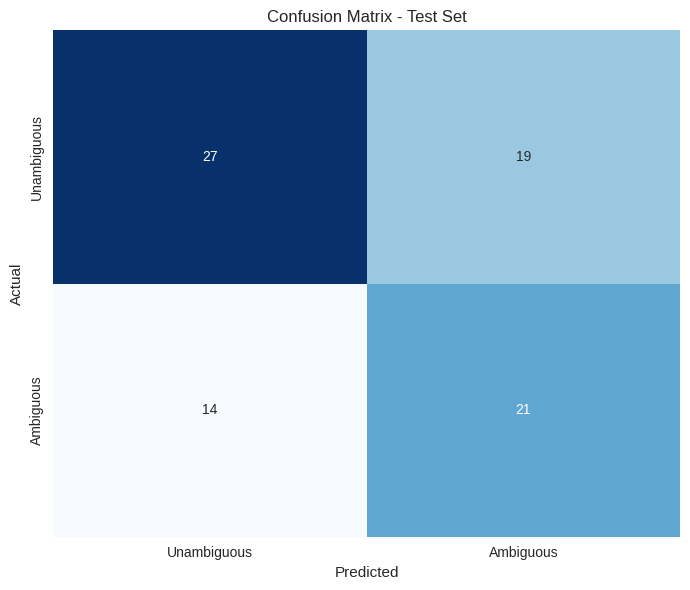


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6585    0.5870    0.6207        46
   Ambiguous     0.5250    0.6000    0.5600        35

    accuracy                         0.5926        81
   macro avg     0.5918    0.5935    0.5903        81
weighted avg     0.6008    0.5926    0.5945        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_spanbert_input_new.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))
    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start)
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df


# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification.

    Features:
    1. max_prob: highest candidate probability (high = one clear winner)
    2. entropy: entropy of distribution (high = ambiguous)
    3. num_candidates: total candidates
    4. top2_ratio: ratio of 2nd to 1st probability (high = ambiguous)
    5. mean_prob: average probability
    6. prob_gap: difference between top 2 probabilities (high = unambiguous)
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')
                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)
                candidate_score_tensors = []

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel = int(cand['start'])
                        e_rel = int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue
                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                # Compute features
                if not candidate_score_tensors or len(candidate_score_tensors) == 0:
                    no_candidates_count += 1
                    features = [0.0, 0.0, 0, 0.0, 0.0, 0.0]
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Feature 1: Max probability
                    max_prob = float(np.max(probs))

                    # Feature 2: Entropy (normalized)
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)

                    # Feature 3: Number of candidates
                    num_candidates = len(probs)

                    # Feature 4: Top-2 ratio
                    sorted_probs = np.sort(probs)[::-1]
                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                    else:
                        top2_ratio = 0.0

                    # Feature 5: Mean probability
                    mean_prob = float(np.mean(probs))

                    # Feature 6: Probability gap (top1 - top2)
                    if len(sorted_probs) >= 2:
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        prob_gap = 1.0  # Only one candidate = maximum gap

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Entropy: {features[1]:.3f}")
                        print(f"  Top2 ratio: {features[3]:.3f}")
                        print(f"  Prob gap: {features[5]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


## **QA Logits**

1-1 srl v1

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.261
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.502

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.134
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.246

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.061
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.394

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.366
  Validation F1 (Ambiguous): 0.6154

Random Forest:
  Best Threshold: 0.332
  Validation F1 (Ambiguous): 0.6531

SVM (Linear Kernel):
  Best Threshold: 0.366
  Validation F1 (Ambiguous): 0.6154

Naive Bayes:
  Best Threshold: 0.448
  Validation F1 (Ambiguous): 0.6829

KNN (k=5):
  Best Threshold: 0.000
  Validation F1 (Ambiguous): 0.5926

Gradient Boosting:
  Best Threshold: 0.376
  Validation F1 (Ambiguous): 0.6341

AdaBoost:
  Best Threshold: 0.481
  Validation F1 (Ambiguous): 0.6341

Selected Model: Naive Bayes
Optimized Threshold: 0.448

STEP 3: Final Test Evaluation


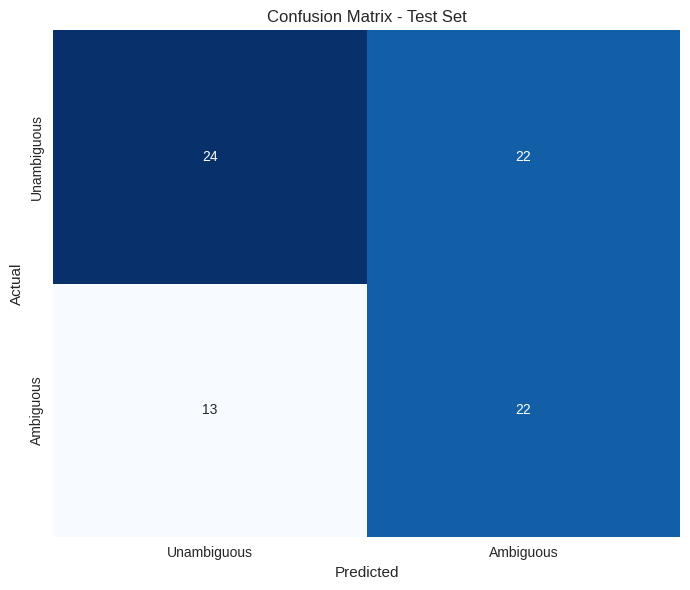


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6486    0.5217    0.5783        46
   Ambiguous     0.5000    0.6286    0.5570        35

    accuracy                         0.5679        81
   macro avg     0.5743    0.5752    0.5676        81
weighted avg     0.5844    0.5679    0.5691        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    # Access the dataframe specific to this dataloader (train, val, or test df)
    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                # Handle potential byte decoding
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = [] # List for new feature
                candidate_pred_dists = []  # Optional: List for distance feature

                
                # Get the row index for the current sample in the batch
                row_idx = batch['row_idx'][i].item()

                # Access the SRL dictionary from the dataframe attached to the dataloader
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        # 1. SpanBERT Score
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # 2. SRL Lookup
                        cand_text = cand['text'].strip().lower()

                        # Default values if not found
                        srl_val = 0
                        dist_val = -1

                        if cand_text in current_srl_dict:
                            srl_val = current_srl_dict[cand_text]['srl_match']
                            dist_val = current_srl_dict[cand_text]['pred_dist']

                        candidate_srl_matches.append(srl_val)
                        candidate_pred_dists.append(dist_val)

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Padding 8 features (6 original + 2 new)
                    features = [0.0] * 8
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- NEW SRL FEATURES ---
                    # Feature 7: Does the top probability candidate have an SRL match?
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index])

                    # Feature 8: Weighted SRL score (Sum of Prob * SRL_Match)
                    weighted_srl = float(np.sum(probs * srl_matches))

                    
                    # dists = np.array(candidate_pred_dists)
                    # weighted_dist = float(np.sum(probs * (dists != -1))) # simple existence check

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


1-1 srl v2

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.261
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.740

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.134
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.757

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.061
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.748

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.407
  Validation F1 (Ambiguous): 0.6809

Random Forest:
  Best Threshold: 0.327
  Validation F1 (Ambiguous): 0.6531

SVM (Linear Kernel):
  Best Threshold: 0.354
  Validation F1 (Ambiguous): 0.6667

Naive Bayes:
  Best Threshold: 0.319
  Validation F1 (Ambiguous): 0.6977

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6190

Gradient Boosting:
  Best Threshold: 0.089
  Validation F1 (Ambiguous): 0.6275

AdaBoost:
  Best Threshold: 0.496
  Validation F1 (Ambiguous): 0.6667

Selected Model: Naive Bayes
Optimized Threshold: 0.319

STEP 3: Final Test Evaluation


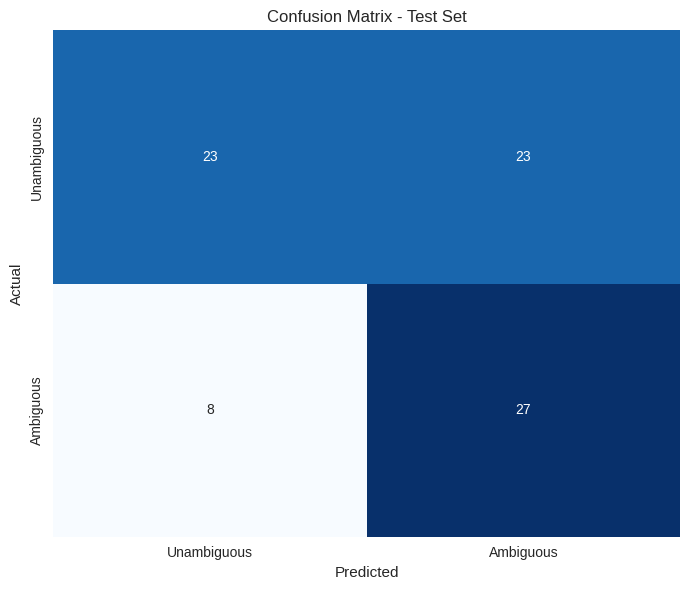


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7419    0.5000    0.5974        46
   Ambiguous     0.5400    0.7714    0.6353        35

    accuracy                         0.6173        81
   macro avg     0.6410    0.6357    0.6163        81
weighted avg     0.6547    0.6173    0.6138        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    Uses best_srl_match to robustly match candidate spans to SRL-records.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []  # SRL match per aligned candidate
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        # Only consider candidates that align to tokens in encoding
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching for this candidate span text
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    features = [0.0] * 8  # 6 original + 2 SRL
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches) if len(candidate_srl_matches) == len(probs) else np.zeros(len(probs))

                    # Existing features
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # New SRL features
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


1-1 srl v3

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.261
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.134
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.061
  Top 1 Has SRL: 0.0
  Top 1 Dist: 20.0

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.406
  Validation F1 (Ambiguous): 0.6809

Random Forest:
  Best Threshold: 0.465
  Validation F1 (Ambiguous): 0.7317

SVM (Linear Kernel):
  Best Threshold: 0.404
  Validation F1 (Ambiguous): 0.6809

Naive Bayes:
  Best Threshold: 0.251
  Validation F1 (Ambiguous): 0.7111

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6190

Gradient Boosting:
  Best Threshold: 0.425
  Validation F1 (Ambiguous): 0.7000

AdaBoost:
  Best Threshold: 0.457
  Validation F1 (Ambiguous): 0.6667

Selected Model: Random Forest
Optimized Threshold: 0.465

STEP 3: Final Test Evaluation


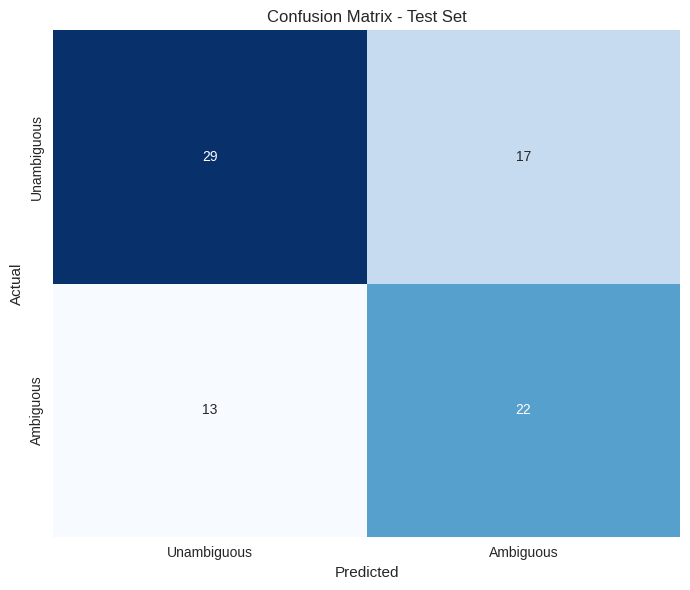


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6905    0.6304    0.6591        46
   Ambiguous     0.5641    0.6286    0.5946        35

    accuracy                         0.6296        81
   macro avg     0.6273    0.6295    0.6268        81
weighted avg     0.6359    0.6296    0.6312        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features AND Distances.
    Feature Vector Length: 10
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Return empty vector of size 10
                    features = [0.0] * 10
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Ensure lengths match (in case something weird happened)
                    if len(candidate_srl_matches) != len(probs):
                        candidate_srl_matches = [0] * len(probs)
                        candidate_pred_dists = [-1] * len(probs)

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)

                    # Normalize distances: replace -1 with penalty (e.g., 20)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- SRL FEATURES ---
                    top1_index = sorted_indices[0]

                    # 7. Top 1 has SRL match?
                    top1_has_srl = float(srl_matches[top1_index])

                    # 8. Weighted SRL score
                    weighted_srl = float(np.sum(probs * srl_matches))

                    # --- DISTANCE FEATURES ---
                    # 9. Distance of Top 1 candidate (lower is usually better)
                    top1_dist = float(clean_dists[top1_index])

                    # 10. Weighted Distance (Average distance weighted by probability)
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl,
                        top1_dist,
                        weighted_dist
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Top 1 Dist: {features[8]:.1f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

## **cosine similarity**

1-2 srl v1

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.402
  Validation F1 (Ambiguous): 0.6667

Random Forest:
  Best Threshold: 0.441
  Validation F1 (Ambiguous): 0.7568

SVM (Linear Kernel):
  Best Threshold: 0.399
  Validation F1 (Ambiguous): 0.6809

Naive Bayes:
  Best Threshold: 0.103
  Validation F1 (Ambiguous): 0.6400

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6047

Gradient Boosting:
  Best Threshold: 0.350
  Validation F1 (Ambiguous): 0.7222

AdaBoost:
  Best Threshold: 0.482
  Validation F1 (Ambiguous): 0.7027

Selected Model: Random Forest
Optimized Threshold: 0.441

STEP 3: Final Test Evaluation


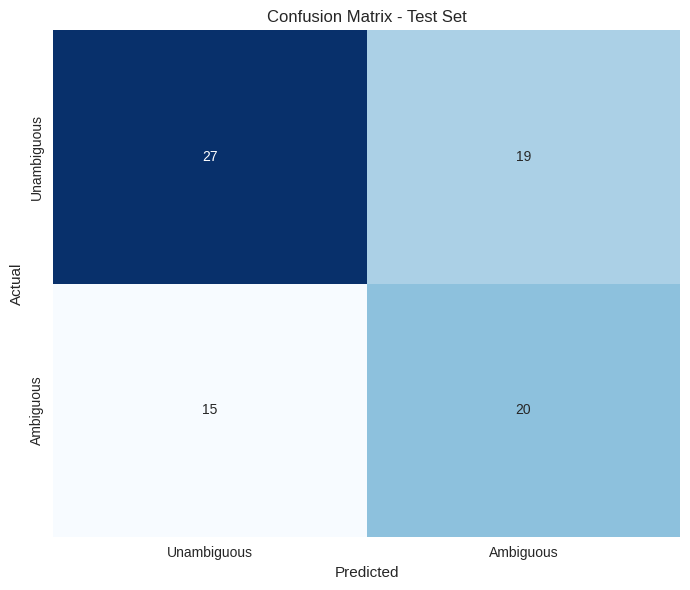


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6429    0.5870    0.6136        46
   Ambiguous     0.5128    0.5714    0.5405        35

    accuracy                         0.5802        81
   macro avg     0.5778    0.5792    0.5771        81
weighted avg     0.5867    0.5802    0.5821        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)

    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


1-2 srl v2

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.394
  Validation F1 (Ambiguous): 0.6667

Random Forest:
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.7317

SVM (Linear Kernel):
  Best Threshold: 0.363
  Validation F1 (Ambiguous): 0.6667

Naive Bayes:
  Best Threshold: 0.098
  Validation F1 (Ambiguous): 0.6275

KNN (k=5):
  Best Threshold: 0.200
  Validation F1 (Ambiguous): 0.6154

Gradient Boosting:
  Best Threshold: 0.299
  Validation F1 (Ambiguous): 0.7179

AdaBoost:
  Best Threshold: 0.462
  Validation F1 (Ambiguous): 0.7027

Selected Model: Random Forest
Optimized Threshold: 0.400

STEP 3: Final Test Evaluation


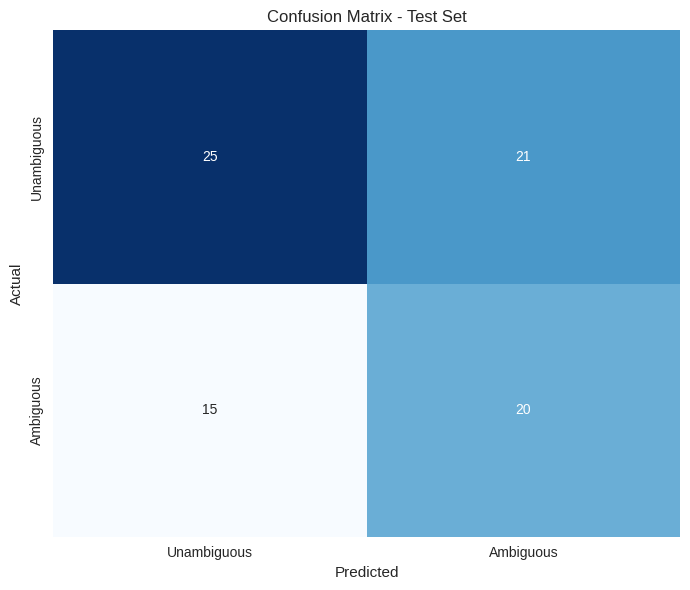


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6250    0.5435    0.5814        46
   Ambiguous     0.4878    0.5714    0.5263        35

    accuracy                         0.5556        81
   macro avg     0.5564    0.5575    0.5539        81
weighted avg     0.5657    0.5556    0.5576        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


1-2 srl v3

Using device: cuda
Using model: SpanBERT/spanbert-base-cased

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.402
  Validation F1 (Ambiguous): 0.6667

Random Forest:
  Best Threshold: 0.441
  Validation F1 (Ambiguous): 0.7568

SVM (Linear Kernel):
  Best Threshold: 0.399
  Validation F1 (Ambiguous): 0.6809

Naive Bayes:
  Best Threshold: 0.103
  Validation F1 (Ambiguous): 0.6400

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6047

Gradient Boosting:
  Best Threshold: 0.350
  Validation F1 (Ambiguous): 0.7222

AdaBoost:
  Best Threshold: 0.482
  Validation F1 (Ambiguous): 0.7027

Selected Model: Random Forest
Optimized Threshold: 0.441

STEP 3: Final Test Evaluation


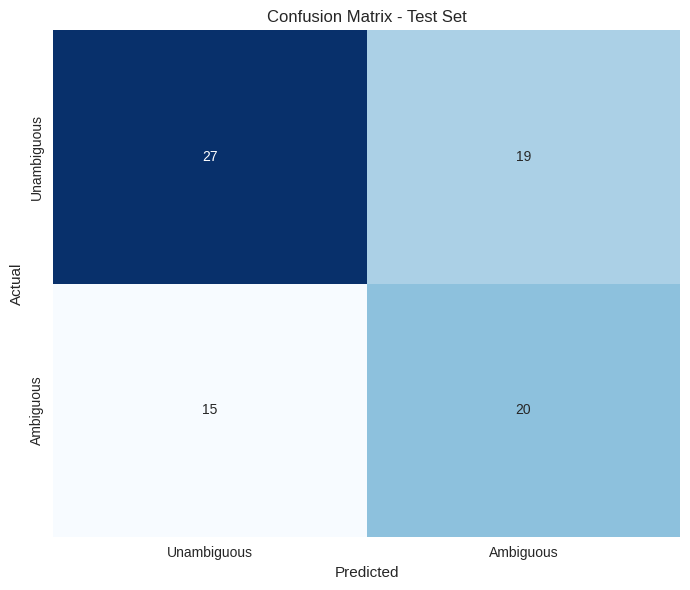


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6429    0.5870    0.6136        46
   Ambiguous     0.5128    0.5714    0.5405        35

    accuracy                         0.5802        81
   macro avg     0.5778    0.5792    0.5771        81
weighted avg     0.5867    0.5802    0.5821        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F
# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

# **mrm8488/spanbert-finetuned-squadv2**

2- baseline

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/spanbert-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.962
  Entropy: 0.140
  Top2 ratio: 0.024
  Prob gap: 0.939

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.909
  Entropy: 0.181
  Top2 ratio: 0.071
  Prob gap: 0.845

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.846
  Entropy: 0.166
  Top2 ratio: 0.161
  Prob gap: 0.710

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.488
  Validation F1 (Ambiguous): 0.7179

Random Forest:
  Best Threshold: 0.438
  Validation F1 (Ambiguous): 0.7179

SVM (Linear Kernel):
  Best Threshold: 0.427
  Validation F1 (Ambiguous): 0.7179

Naive Bayes:
  Best Threshold: 0.506
  Validation F1 (Ambiguous): 0.6857

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6341

Gradient Boosting:
  Best Threshold: 0.362
  Validation F1 (Ambiguous): 0.7027

AdaBoost:
  Best Threshold: 0.481
  Validation F1 (Ambiguous): 0.7000

Selected Model: Logistic Regression
Optimized Threshold: 0.488

STEP 3: Final Test Evaluation


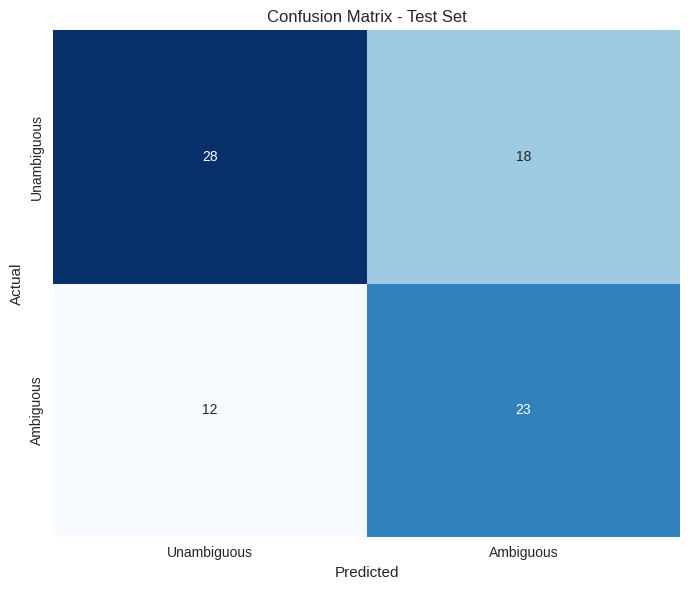


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7000    0.6087    0.6512        46
   Ambiguous     0.5610    0.6571    0.6053        35

    accuracy                         0.6296        81
   macro avg     0.6305    0.6329    0.6282        81
weighted avg     0.6399    0.6296    0.6313        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_spanbert_input_new.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))
    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start)
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df


# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification.

    Features:
    1. max_prob: highest candidate probability (high = one clear winner)
    2. entropy: entropy of distribution (high = ambiguous)
    3. num_candidates: total candidates
    4. top2_ratio: ratio of 2nd to 1st probability (high = ambiguous)
    5. mean_prob: average probability
    6. prob_gap: difference between top 2 probabilities (high = unambiguous)
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')
                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)
                candidate_score_tensors = []

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel = int(cand['start'])
                        e_rel = int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue
                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                # Compute features
                if not candidate_score_tensors or len(candidate_score_tensors) == 0:
                    no_candidates_count += 1
                    features = [0.0, 0.0, 0, 0.0, 0.0, 0.0]
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Feature 1: Max probability
                    max_prob = float(np.max(probs))

                    # Feature 2: Entropy (normalized)
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)

                    # Feature 3: Number of candidates
                    num_candidates = len(probs)

                    # Feature 4: Top-2 ratio
                    sorted_probs = np.sort(probs)[::-1]
                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                    else:
                        top2_ratio = 0.0

                    # Feature 5: Mean probability
                    mean_prob = float(np.mean(probs))

                    # Feature 6: Probability gap (top1 - top2)
                    if len(sorted_probs) >= 2:
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        prob_gap = 1.0  # Only one candidate = maximum gap

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Entropy: {features[1]:.3f}")
                        print(f"  Top2 ratio: {features[3]:.3f}")
                        print(f"  Prob gap: {features[5]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


## **QA logits**

2-1 srl v1

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of the model checkpoint at mrm8488/spanbert-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.962
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.968

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.909
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.909

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.846
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.846

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.412
  Validation F1 (Ambiguous): 0.6250

Random Forest:
  Best Threshold: 0.312
  Validation F1 (Ambiguous): 0.6957

SVM (Linear Kernel):
  Best Threshold: 0.396
  Validation F1 (Ambiguous): 0.6383

Naive Bayes:
  Best Threshold: 0.264
  Validation F1 (Ambiguous): 0.6667

KNN (k=5):
  Best Threshold: 0.200
  Validation F1 (Ambiguous): 0.6383

Gradient Boosting:
  Best Threshold: 0.105
  Validation F1 (Ambiguous): 0.6531

AdaBoost:
  Best Threshold: 0.459
  Validation F1 (Ambiguous): 0.6087

Selected Model: Random Forest
Optimized Threshold: 0.312

STEP 3: Final Test Evaluation


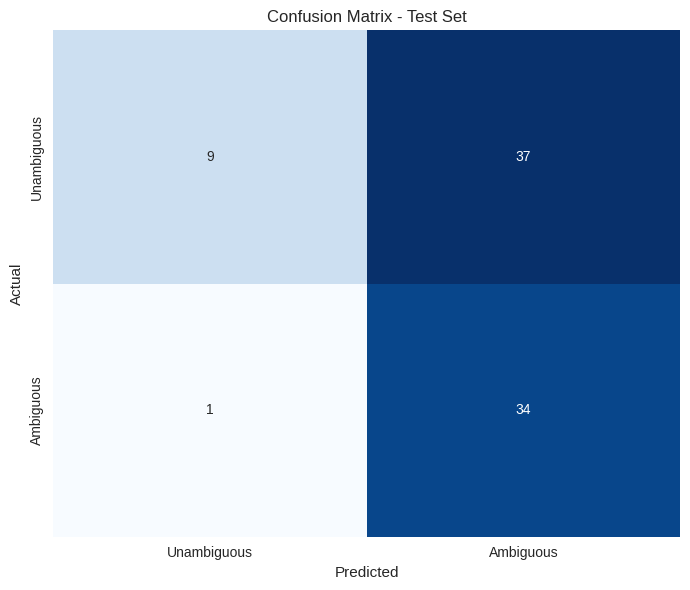


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.9000    0.1957    0.3214        46
   Ambiguous     0.4789    0.9714    0.6415        35

    accuracy                         0.5309        81
   macro avg     0.6894    0.5835    0.4815        81
weighted avg     0.7180    0.5309    0.4597        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    # Access the dataframe specific to this dataloader (train, val, or test df)
    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                # Handle potential byte decoding
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = [] # List for new feature
                candidate_pred_dists = []  # Optional: List for distance feature

                
                # Get the row index for the current sample in the batch
                row_idx = batch['row_idx'][i].item()

                # Access the SRL dictionary from the dataframe attached to the dataloader
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']
                # -------------------

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        # 1. SpanBERT Score
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # 2. SRL Lookup
                        cand_text = cand['text'].strip().lower()

                        # Default values if not found
                        srl_val = 0
                        dist_val = -1

                        if cand_text in current_srl_dict:
                            srl_val = current_srl_dict[cand_text]['srl_match']
                            dist_val = current_srl_dict[cand_text]['pred_dist']

                        candidate_srl_matches.append(srl_val)
                        candidate_pred_dists.append(dist_val)

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Padding 8 features (6 original + 2 new)
                    features = [0.0] * 8
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- NEW SRL FEATURES ---
                    # Feature 7: Does the top probability candidate have an SRL match?
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index])

                    # Feature 8: Weighted SRL score (Sum of Prob * SRL_Match)
                    weighted_srl = float(np.sum(probs * srl_matches))

                    
                    # dists = np.array(candidate_pred_dists)
                    # weighted_dist = float(np.sum(probs * (dists != -1))) # simple existence check

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


2-1 srl v2

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of the model checkpoint at mrm8488/spanbert-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.962
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.977

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.909
  Top 1 Has SRL: 1.0
  Weighted SRL: 1.000

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.846
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.982

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.445
  Validation F1 (Ambiguous): 0.6512

Random Forest:
  Best Threshold: 0.307
  Validation F1 (Ambiguous): 0.6667

SVM (Linear Kernel):
  Best Threshold: 0.391
  Validation F1 (Ambiguous): 0.6512

Naive Bayes:
  Best Threshold: 0.391
  Validation F1 (Ambiguous): 0.7000

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6154

Gradient Boosting:
  Best Threshold: 0.259
  Validation F1 (Ambiguous): 0.6829

AdaBoost:
  Best Threshold: 0.441
  Validation F1 (Ambiguous): 0.6400

Selected Model: Naive Bayes
Optimized Threshold: 0.391

STEP 3: Final Test Evaluation


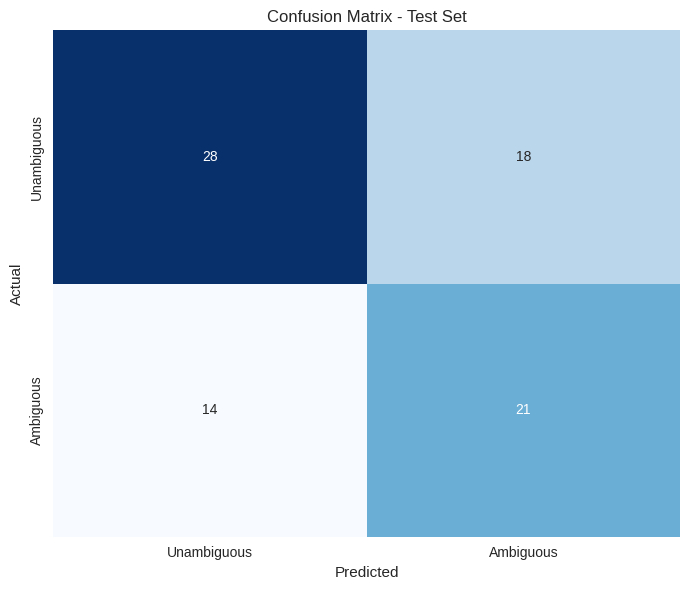


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6667    0.6087    0.6364        46
   Ambiguous     0.5385    0.6000    0.5676        35

    accuracy                         0.6049        81
   macro avg     0.6026    0.6043    0.6020        81
weighted avg     0.6113    0.6049    0.6066        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    Uses best_srl_match to robustly match candidate spans to SRL-records.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []  # SRL match per aligned candidate
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        # Only consider candidates that align to tokens in encoding
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching for this candidate span text
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    features = [0.0] * 8  # 6 original + 2 SRL
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches) if len(candidate_srl_matches) == len(probs) else np.zeros(len(probs))

                    # Existing features
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # New SRL features
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


2-1 srl v3

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


Some weights of the model checkpoint at mrm8488/spanbert-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.962
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.909
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.846
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.334
  Validation F1 (Ambiguous): 0.6250

Random Forest:
  Best Threshold: 0.483
  Validation F1 (Ambiguous): 0.6667

SVM (Linear Kernel):
  Best Threshold: 0.404
  Validation F1 (Ambiguous): 0.6522

Naive Bayes:
  Best Threshold: 0.352
  Validation F1 (Ambiguous): 0.6500

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6316

Gradient Boosting:
  Best Threshold: 0.238
  Validation F1 (Ambiguous): 0.7000

AdaBoost:
  Best Threshold: 0.445
  Validation F1 (Ambiguous): 0.6275

Selected Model: Gradient Boosting
Optimized Threshold: 0.238

STEP 3: Final Test Evaluation


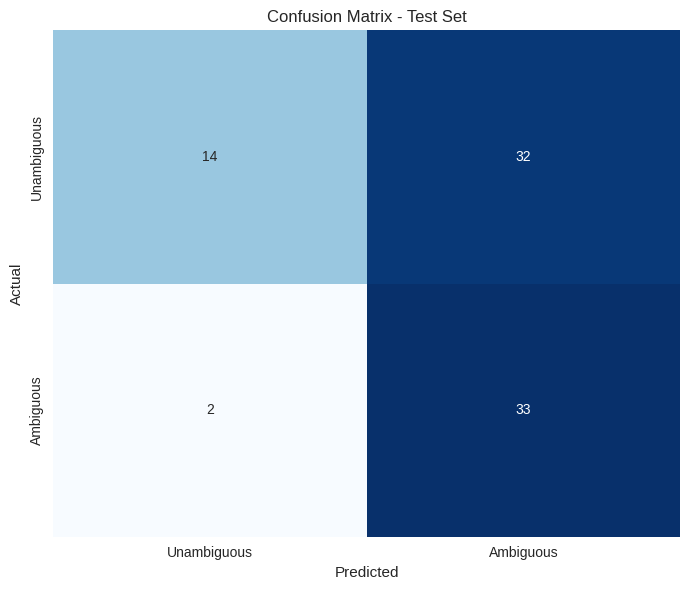


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.8750    0.3043    0.4516        46
   Ambiguous     0.5077    0.9429    0.6600        35

    accuracy                         0.5802        81
   macro avg     0.6913    0.6236    0.5558        81
weighted avg     0.7163    0.5802    0.5417        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features AND Distances.
    Feature Vector Length: 10
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Return empty vector of size 10
                    features = [0.0] * 10
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Ensure lengths match (in case something weird happened)
                    if len(candidate_srl_matches) != len(probs):
                        candidate_srl_matches = [0] * len(probs)
                        candidate_pred_dists = [-1] * len(probs)

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)

                    # Normalize distances: replace -1 with penalty (e.g., 20)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- SRL FEATURES ---
                    top1_index = sorted_indices[0]

                    # 7. Top 1 has SRL match?
                    top1_has_srl = float(srl_matches[top1_index])

                    # 8. Weighted SRL score
                    weighted_srl = float(np.sum(probs * srl_matches))

                    # --- DISTANCE FEATURES ---
                    # 9. Distance of Top 1 candidate (lower is usually better)
                    top1_dist = float(clean_dists[top1_index])

                    # 10. Weighted Distance (Average distance weighted by probability)
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl,
                        top1_dist,
                        weighted_dist
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Top 1 Dist: {features[8]:.1f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

## **cosine similarity**

2-2 srl v1

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.354
  Validation F1 (Ambiguous): 0.6000

Random Forest:
  Best Threshold: 0.377
  Validation F1 (Ambiguous): 0.7179

SVM (Linear Kernel):
  Best Threshold: 0.398
  Validation F1 (Ambiguous): 0.6275

Naive Bayes:
  Best Threshold: 0.062
  Validation F1 (Ambiguous): 0.6275

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6667

Gradient Boosting:
  Best Threshold: 0.265
  Validation F1 (Ambiguous): 0.7143

AdaBoost:
  Best Threshold: 0.462
  Validation F1 (Ambiguous): 0.6364

Selected Model: Random Forest
Optimized Threshold: 0.377

STEP 3: Final Test Evaluation


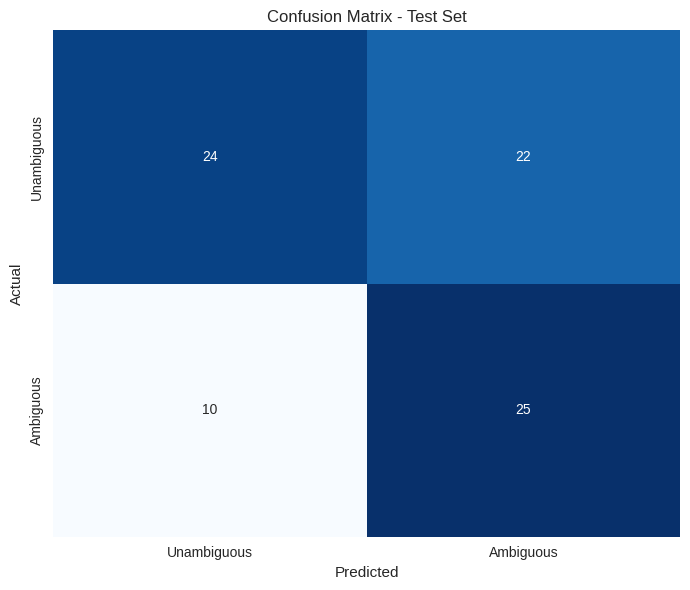


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7059    0.5217    0.6000        46
   Ambiguous     0.5319    0.7143    0.6098        35

    accuracy                         0.6049        81
   macro avg     0.6189    0.6180    0.6049        81
weighted avg     0.6307    0.6049    0.6042        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


2-2 srl v2

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.351
  Validation F1 (Ambiguous): 0.6000

Random Forest:
  Best Threshold: 0.408
  Validation F1 (Ambiguous): 0.7222

SVM (Linear Kernel):
  Best Threshold: 0.388
  Validation F1 (Ambiguous): 0.6250

Naive Bayes:
  Best Threshold: 0.079
  Validation F1 (Ambiguous): 0.6250

KNN (k=5):
  Best Threshold: 0.200
  Validation F1 (Ambiguous): 0.6400

Gradient Boosting:
  Best Threshold: 0.246
  Validation F1 (Ambiguous): 0.7000

AdaBoost:
  Best Threshold: 0.446
  Validation F1 (Ambiguous): 0.6522

Selected Model: Random Forest
Optimized Threshold: 0.408

STEP 3: Final Test Evaluation


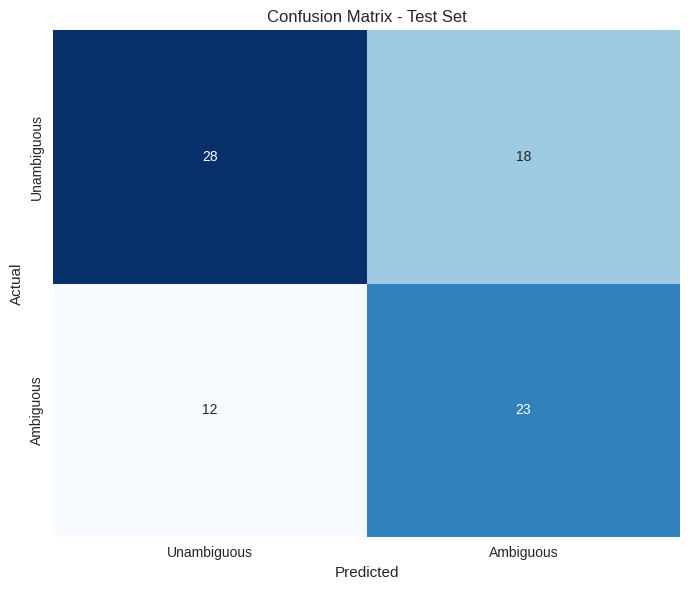


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7000    0.6087    0.6512        46
   Ambiguous     0.5610    0.6571    0.6053        35

    accuracy                         0.6296        81
   macro avg     0.6305    0.6329    0.6282        81
weighted avg     0.6399    0.6296    0.6313        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


2-2 srl v3

Using device: cuda
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.354
  Validation F1 (Ambiguous): 0.6000

Random Forest:
  Best Threshold: 0.377
  Validation F1 (Ambiguous): 0.7179

SVM (Linear Kernel):
  Best Threshold: 0.398
  Validation F1 (Ambiguous): 0.6275

Naive Bayes:
  Best Threshold: 0.062
  Validation F1 (Ambiguous): 0.6275

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6667

Gradient Boosting:
  Best Threshold: 0.265
  Validation F1 (Ambiguous): 0.7143

AdaBoost:
  Best Threshold: 0.462
  Validation F1 (Ambiguous): 0.6364

Selected Model: Random Forest
Optimized Threshold: 0.377

STEP 3: Final Test Evaluation


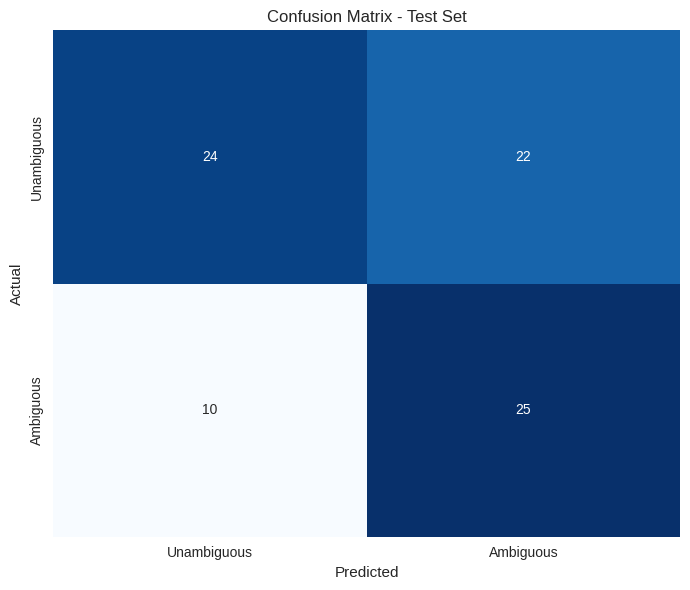


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7059    0.5217    0.6000        46
   Ambiguous     0.5319    0.7143    0.6098        35

    accuracy                         0.6049        81
   macro avg     0.6189    0.6180    0.6049        81
weighted avg     0.6307    0.6049    0.6042        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

# **mrm8488/spanbert-large-finetuned-squadv2**

3- baseline

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/667M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/667M [00:00<?, ?B/s]


STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.735
  Entropy: 0.594
  Top2 ratio: 0.206
  Prob gap: 0.583

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.703
  Entropy: 0.435
  Top2 ratio: 0.256
  Prob gap: 0.523

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.402
  Entropy: 0.489
  Top2 ratio: 0.840
  Prob gap: 0.065

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6038

Random Forest:
  Best Threshold: 0.272
  Validation F1 (Ambiguous): 0.6038

SVM (Linear Kernel):
  Best Threshold: 0.377
  Validation F1 (Ambiguous): 0.6038

Naive Bayes:
  Best Threshold: 0.120
  Validation F1 (Ambiguous): 0.5926

KNN (k=5):
  Best Threshold: 0.600
  Validation F1 (Ambiguous): 0.6061

Gradient Boosting:
  Best Threshold: 0.116
  Validation F1 (Ambiguous): 0.6275

AdaBoost:
  Best Threshold: 0.427
  Validation F1 (Ambiguous): 0.6038

Selected Model: Gradient Boosting
Optimized Threshold: 0.116

STEP 3: Final Test Evaluation


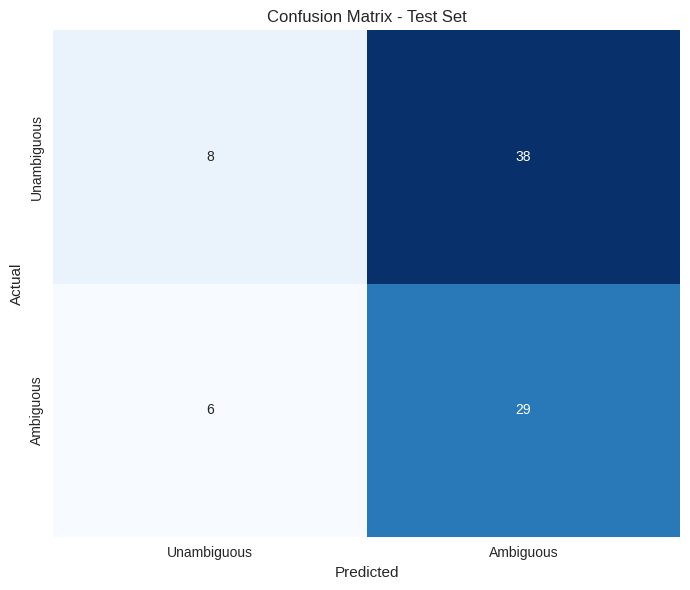


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.5714    0.1739    0.2667        46
   Ambiguous     0.4328    0.8286    0.5686        35

    accuracy                         0.4568        81
   macro avg     0.5021    0.5012    0.4176        81
weighted avg     0.5115    0.4568    0.3971        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_spanbert_input_new.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))
    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start)
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df


# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification.

    Features:
    1. max_prob: highest candidate probability (high = one clear winner)
    2. entropy: entropy of distribution (high = ambiguous)
    3. num_candidates: total candidates
    4. top2_ratio: ratio of 2nd to 1st probability (high = ambiguous)
    5. mean_prob: average probability
    6. prob_gap: difference between top 2 probabilities (high = unambiguous)
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')
                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)
                candidate_score_tensors = []

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel = int(cand['start'])
                        e_rel = int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue
                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                # Compute features
                if not candidate_score_tensors or len(candidate_score_tensors) == 0:
                    no_candidates_count += 1
                    features = [0.0, 0.0, 0, 0.0, 0.0, 0.0]
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Feature 1: Max probability
                    max_prob = float(np.max(probs))

                    # Feature 2: Entropy (normalized)
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)

                    # Feature 3: Number of candidates
                    num_candidates = len(probs)

                    # Feature 4: Top-2 ratio
                    sorted_probs = np.sort(probs)[::-1]
                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                    else:
                        top2_ratio = 0.0

                    # Feature 5: Mean probability
                    mean_prob = float(np.mean(probs))

                    # Feature 6: Probability gap (top1 - top2)
                    if len(sorted_probs) >= 2:
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        prob_gap = 1.0  # Only one candidate = maximum gap

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Entropy: {features[1]:.3f}")
                        print(f"  Top2 ratio: {features[3]:.3f}")
                        print(f"  Prob gap: {features[5]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


## **QA logits**

3-1 srl v1

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.735
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.763

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.703
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.181

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.402
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.369

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.340
  Validation F1 (Ambiguous): 0.6038

Random Forest:
  Best Threshold: 0.281
  Validation F1 (Ambiguous): 0.6038

SVM (Linear Kernel):
  Best Threshold: 0.369
  Validation F1 (Ambiguous): 0.6038

Naive Bayes:
  Best Threshold: 0.072
  Validation F1 (Ambiguous): 0.5926

KNN (k=5):
  Best Threshold: 0.000
  Validation F1 (Ambiguous): 0.5926

Gradient Boosting:
  Best Threshold: 0.054
  Validation F1 (Ambiguous): 0.6275

AdaBoost:
  Best Threshold: 0.417
  Validation F1 (Ambiguous): 0.6038

Selected Model: Gradient Boosting
Optimized Threshold: 0.054

STEP 3: Final Test Evaluation


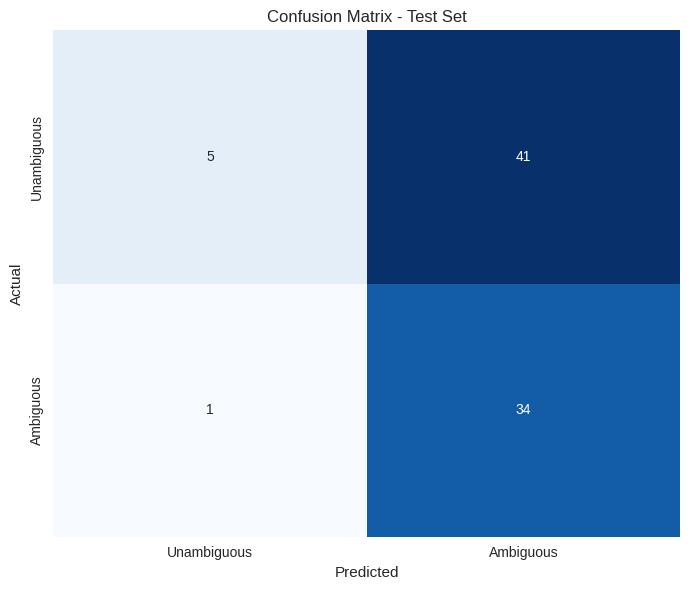


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.8333    0.1087    0.1923        46
   Ambiguous     0.4533    0.9714    0.6182        35

    accuracy                         0.4815        81
   macro avg     0.6433    0.5401    0.4052        81
weighted avg     0.6691    0.4815    0.3763        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    # Access the dataframe specific to this dataloader (train, val, or test df)
    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                # Handle potential byte decoding
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = [] # List for new feature
                candidate_pred_dists = []  # Optional: List for distance feature

                
                # Get the row index for the current sample in the batch
                row_idx = batch['row_idx'][i].item()

                # Access the SRL dictionary from the dataframe attached to the dataloader
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']
                # -------------------

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        # 1. SpanBERT Score
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # 2. SRL Lookup
                        cand_text = cand['text'].strip().lower()

                        # Default values if not found
                        srl_val = 0
                        dist_val = -1

                        if cand_text in current_srl_dict:
                            srl_val = current_srl_dict[cand_text]['srl_match']
                            dist_val = current_srl_dict[cand_text]['pred_dist']

                        candidate_srl_matches.append(srl_val)
                        candidate_pred_dists.append(dist_val)

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Padding 8 features (6 original + 2 new)
                    features = [0.0] * 8
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- NEW SRL FEATURES ---
                    # Feature 7: Does the top probability candidate have an SRL match?
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index])

                    # Feature 8: Weighted SRL score (Sum of Prob * SRL_Match)
                    weighted_srl = float(np.sum(probs * srl_matches))

                    
                    # dists = np.array(candidate_pred_dists)
                    # weighted_dist = float(np.sum(probs * (dists != -1))) # simple existence check

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl]

                # Verbose output for first few examples
                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


3-1 srl v2

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.735
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.915

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.703
  Top 1 Has SRL: 1.0
  Weighted SRL: 0.998

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.402
  Top 1 Has SRL: 0.0
  Weighted SRL: 0.441

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.369
  Validation F1 (Ambiguous): 0.6038

Random Forest:
  Best Threshold: 0.313
  Validation F1 (Ambiguous): 0.6154

SVM (Linear Kernel):
  Best Threshold: 0.378
  Validation F1 (Ambiguous): 0.6038

Naive Bayes:
  Best Threshold: 0.089
  Validation F1 (Ambiguous): 0.5926

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6341

Gradient Boosting:
  Best Threshold: 0.136
  Validation F1 (Ambiguous): 0.6667

AdaBoost:
  Best Threshold: 0.418
  Validation F1 (Ambiguous): 0.6038

Selected Model: Gradient Boosting
Optimized Threshold: 0.136

STEP 3: Final Test Evaluation


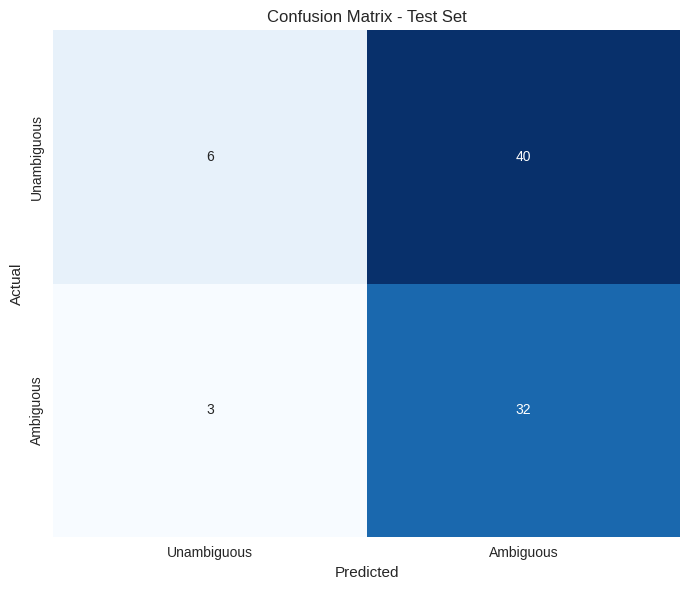


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.6667    0.1304    0.2182        46
   Ambiguous     0.4444    0.9143    0.5981        35

    accuracy                         0.4691        81
   macro avg     0.5556    0.5224    0.4082        81
weighted avg     0.5706    0.4691    0.3824        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features.
    Uses best_srl_match to robustly match candidate spans to SRL-records.
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []  # SRL match per aligned candidate
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        # Only consider candidates that align to tokens in encoding
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching for this candidate span text
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    features = [0.0] * 8  # 6 original + 2 SRL
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()
                    srl_matches = np.array(candidate_srl_matches) if len(candidate_srl_matches) == len(probs) else np.zeros(len(probs))

                    # Existing features
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # New SRL features
                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Weighted SRL: {features[7]:.3f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


3-1 srl v3

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Example 0:
  True label: Unambiguous
  Num candidates: 4
  Max prob: 0.735
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 1:
  True label: Unambiguous
  Num candidates: 8
  Max prob: 0.703
  Top 1 Has SRL: 1.0
  Top 1 Dist: 0.0

Example 2:
  True label: Ambiguous
  Num candidates: 20
  Max prob: 0.402
  Top 1 Has SRL: 0.0
  Top 1 Dist: 20.0

Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.370
  Validation F1 (Ambiguous): 0.6038

Random Forest:
  Best Threshold: 0.279
  Validation F1 (Ambiguous): 0.6038

SVM (Linear Kernel):
  Best Threshold: 0.422
  Validation F1 (Ambiguous): 0.6250

Naive Bayes:
  Best Threshold: 0.100
  Validation F1 (Ambiguous): 0.5926

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6190

Gradient Boosting:
  Best Threshold: 0.048
  Validation F1 (Ambiguous): 0.6038

AdaBoost:
  Best Threshold: 0.451
  Validation F1 (Ambiguous): 0.6038

Selected Model: SVM (Linear Kernel)
Optimized Threshold: 0.422

STEP 3: Final Test Evaluation


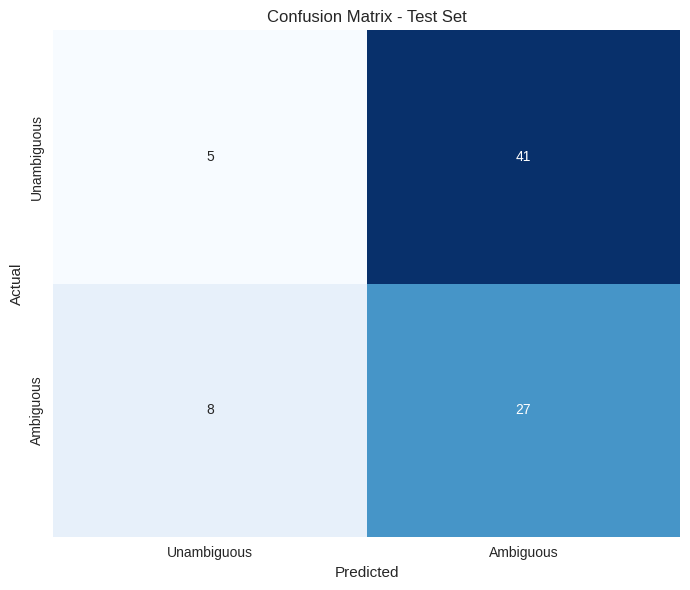


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.3846    0.1087    0.1695        46
   Ambiguous     0.3971    0.7714    0.5243        35

    accuracy                         0.3951        81
   macro avg     0.3908    0.4401    0.3469        81
weighted avg     0.3900    0.3951    0.3228        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    """
    Extract features from QA model for classification, including SRL features AND Distances.
    Feature Vector Length: 10
    """
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_score_tensors = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                # Row index to lookup srl_data
                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    for cand in candidates:
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        start_token_idx, end_token_idx = align_span_to_token_indices(
                            s_rel, e_rel, offmap, tt
                        )
                        if start_token_idx is None or end_token_idx is None:
                            continue

                        s_logit = start_logits[start_token_idx]
                        e_logit = end_logits[end_token_idx]
                        span_score = s_logit + e_logit
                        candidate_score_tensors.append(span_score)

                        # Robust SRL matching
                        cand_text = cand['text']
                        srl_val, dist_val, best_score, best_key = best_srl_match(
                            cand_text,
                            current_srl_dict,
                            fuzzy_threshold=0.70,
                            embed_threshold=0.65,
                            combined_threshold=0.75,
                            embed_model=EMBED_MODEL
                        )

                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_score_tensors:
                    no_candidates_count += 1
                    # Return empty vector of size 10
                    features = [0.0] * 10
                else:
                    scores_tensor = torch.stack(candidate_score_tensors)
                    probs = torch.softmax(scores_tensor, dim=0).cpu().numpy()

                    # Ensure lengths match (in case something weird happened)
                    if len(candidate_srl_matches) != len(probs):
                        candidate_srl_matches = [0] * len(probs)
                        candidate_pred_dists = [-1] * len(probs)

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)

                    # Normalize distances: replace -1 with penalty (e.g., 20)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- EXISTING FEATURES ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    # --- SRL FEATURES ---
                    top1_index = sorted_indices[0]

                    # 7. Top 1 has SRL match?
                    top1_has_srl = float(srl_matches[top1_index])

                    # 8. Weighted SRL score
                    weighted_srl = float(np.sum(probs * srl_matches))

                    # --- DISTANCE FEATURES ---
                    # 9. Distance of Top 1 candidate (lower is usually better)
                    top1_dist = float(clean_dists[top1_index])

                    # 10. Weighted Distance (Average distance weighted by probability)
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [
                        max_prob,
                        normalized_entropy,
                        num_candidates,
                        top2_ratio,
                        mean_prob,
                        prob_gap,
                        top1_has_srl,
                        weighted_srl,
                        top1_dist,
                        weighted_dist
                    ]

                if verbose and batch_idx == 0 and i < 3:
                    label_i = int(labels[i].item())
                    print(f"\nExample {i}:")
                    print(f"  True label: {'Ambiguous' if label_i == 1 else 'Unambiguous'}")
                    print(f"  Num candidates: {features[2]}")
                    if features[2] > 0:
                        print(f"  Max prob: {features[0]:.3f}")
                        print(f"  Top 1 Has SRL: {features[6]:.1f}")
                        print(f"  Top 1 Dist: {features[8]:.1f}")

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    if no_candidates_count > 0:
        print(f"  Note: {no_candidates_count} instances had no aligned candidates")

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

## **cosine similarity**

3-2 srl v1

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.374
  Validation F1 (Ambiguous): 0.6275

Random Forest:
  Best Threshold: 0.540
  Validation F1 (Ambiguous): 0.6471

SVM (Linear Kernel):
  Best Threshold: 0.393
  Validation F1 (Ambiguous): 0.6531

Naive Bayes:
  Best Threshold: 0.172
  Validation F1 (Ambiguous): 0.6531

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6522

Gradient Boosting:
  Best Threshold: 0.031
  Validation F1 (Ambiguous): 0.5926

AdaBoost:
  Best Threshold: 0.417
  Validation F1 (Ambiguous): 0.6154

Selected Model: SVM (Linear Kernel)
Optimized Threshold: 0.393

STEP 3: Final Test Evaluation


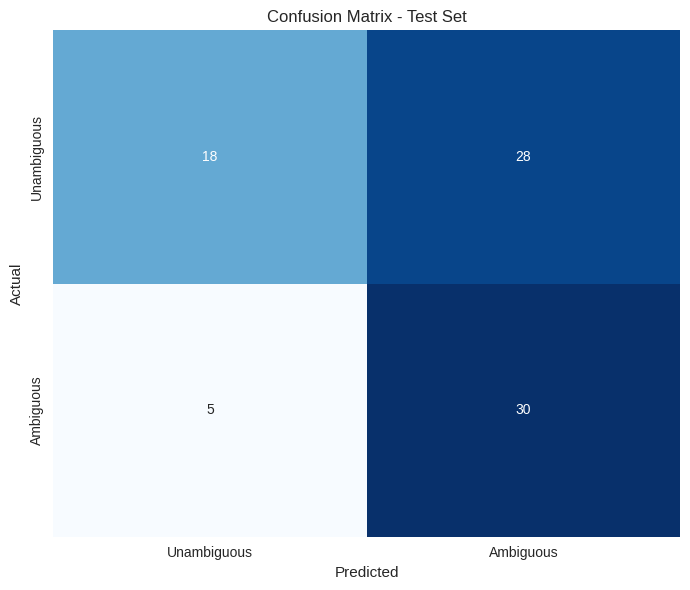


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7826    0.3913    0.5217        46
   Ambiguous     0.5172    0.8571    0.6452        35

    accuracy                         0.5926        81
   macro avg     0.6499    0.6242    0.5835        81
weighted avg     0.6679    0.5926    0.5751        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding

import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Create an SRL Lookup Dictionary ---
    # Structure: { 'group_id': { 'candidate_text_lower': { 'srl_match': 1, 'dist': 0 } } }
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip().lower()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use
        srl_lookup[gid][cand_text] = {
            'srl_match': row['SRL_Match'],
            'pred_dist': row['Predicate_Distance']
        }
    

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        
        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {}) # Pass the SRL data for this group
            })

    eval_df = pd.DataFrame(evaluation_data)
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
# Create candidate spans from NOUN/PROPN tokens with optional left expansion
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))

            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break

            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))

    return spans

# Multi-source candidate extraction
def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallback: nearest NOUN/PROPN
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            # Fallback: content words only
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates


# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }


# -------------------------
# Alignment
# -------------------------
# Align character spans to token indices
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None


# -------------------------
# Feature Extraction
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)


# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    """Train a classifier with class weighting and threshold tuning."""
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    # 1. Use class_weight='balanced' to punish missing Ambiguous cases
    classifiers = {
        'Logistic Regression': LogisticRegression(
            random_state=RANDOM_SEED,
            max_iter=1000,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            max_depth=5,
            class_weight='balanced'
        ),
        'SVM (Linear Kernel)': SVC(
            kernel='linear',
            probability=True,
            class_weight='balanced',
            random_state=RANDOM_SEED
        ),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(
            n_neighbors=5
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED
        )
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        # Train
        clf.fit(train_features, train_labels)

        # Get probabilities instead of hard predictions
        val_probs = clf.predict_proba(val_features)[:, 1]

        # 2. Dynamic Threshold Tuning
        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)

        # Calculate F1 for every possible threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx]
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))


# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)


    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    test_probs = classifier.predict_proba(test_features)[:, 1]

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


3-2 srl v2

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.359
  Validation F1 (Ambiguous): 0.6275

Random Forest:
  Best Threshold: 0.558
  Validation F1 (Ambiguous): 0.6061

SVM (Linear Kernel):
  Best Threshold: 0.378
  Validation F1 (Ambiguous): 0.6531

Naive Bayes:
  Best Threshold: 0.148
  Validation F1 (Ambiguous): 0.6531

KNN (k=5):
  Best Threshold: 0.000
  Validation F1 (Ambiguous): 0.5926

Gradient Boosting:
  Best Threshold: 0.078
  Validation F1 (Ambiguous): 0.6000

AdaBoost:
  Best Threshold: 0.446
  Validation F1 (Ambiguous): 0.6250

Selected Model: SVM (Linear Kernel)
Optimized Threshold: 0.378

STEP 3: Final Test Evaluation


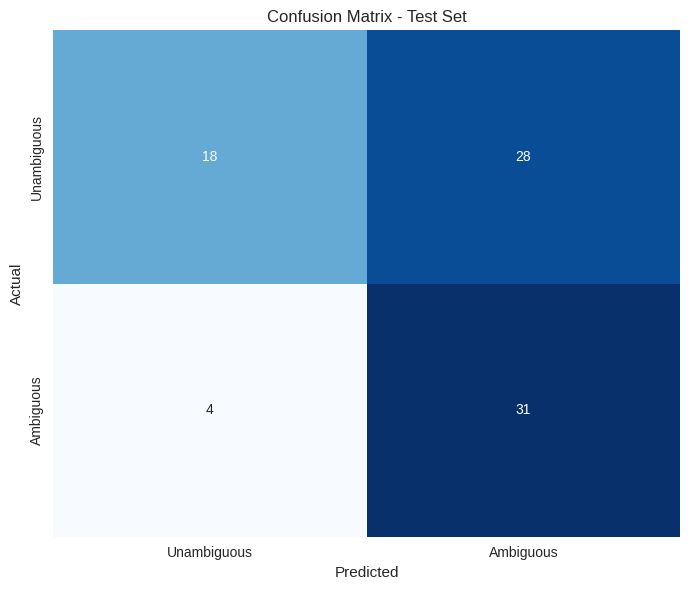


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.8182    0.3913    0.5294        46
   Ambiguous     0.5254    0.8857    0.6596        35

    accuracy                         0.6049        81
   macro avg     0.6718    0.6385    0.5945        81
weighted avg     0.6917    0.6049    0.5857        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: adds robust span -> SRL matching using fuzzy matching + optional embedding similarity.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_srl_final.csv"
BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
# Embedding model (optional). If not installed, matching will fall back to fuzzy-only (if available),
# otherwise exact-match only.
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # choose a lightweight model; change if you prefer another
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled. Install rapidfuzz for better matching.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching:
      - lowercasing
      - remove punctuation (keep alphanumerics and # for things like 'C#')
      - collapse whitespace
      - strip leading determiners ('the', 'a', 'an')
    """
    if text is None:
        return ""
    t = str(text).lower()
    # preserve # and alphanum, remove other punctuation
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    """Return fuzzy token-set ratio in range [0,1]. If rapidfuzz unavailable, return 0."""
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def embedding_similarity(a, b, embed_model):
    """
    Return cosine similarity between a and b using SentenceTransformer.
    If embed_model is None, return 0.
    """
    if embed_model is None or util is None:
        return 0.0
    try:
        emb = embed_model.encode([a, b], convert_to_tensor=True)
        return float(util.cos_sim(emb[0], emb[1]))
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.

    current_srl_dict: mapping str_key -> {'srl_match': int, 'pred_dist': int}
      keys are expected to be the Candidate_Antecedent values saved in preprocess stage,
      but they will be normalized before comparison.

    Returns (srl_val, pred_dist, best_score, best_key) where:
      - srl_val: 0/1 (default 0)
      - pred_dist: integer distance or -1 if unknown
      - best_score: matching score (0..1)
      - best_key: the SRL-key matched (original key) or None
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match (fast path)
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    # Precompute embedding for candidate if needed
    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        # Fuzzy similarity
        f_score = fuzzy_similarity(cand_norm, key_norm)

        # Embedding similarity
        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        # Combined score strategy:
        # - If both are available, combine them (weighted average).
        # - If only fuzzy available, use fuzzy.
        # - If only embedding available, use embedding.
        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        # Keep best
        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzzy_similarity == 0):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    # Not a confident match
    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
# Parse CSV and extract pronoun positions
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    # Keep original keys but we'll normalize at match time
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        # Store the features you want to use (keep original string key)
        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction 
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    # Noun chunks
    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    # NER entities
    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    # POS-based spans
    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    # Deduplicate by character span
    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    # Fallbacks 
    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        # Centered slice around pronoun
        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'context_offset': torch.tensor(int(start_char), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction (with improved SRL matching)
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier 
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        # Some classifiers may not implement predict_proba; wrap in try/except
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            # fallback: use decision_function then min-max scale
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils 
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")


3-2 srl v3

Using device: cuda
Using model: mrm8488/spanbert-large-finetuned-squadv2

PREPROCESSING DATA (WITH SRL)
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train/Validation/Test Split
Train Set Size:      148 (55.4%)
Validation Set Size: 38 (14.2%)
Test Set Size:       81 (30.3%)

STEP 2: Extracting Features for Few-Shot Learning

Processing train set...


Extracting features:   0%|          | 0/19 [00:00<?, ?it/s]


Processing validation set...


Extracting features:   0%|          | 0/5 [00:00<?, ?it/s]


Processing test set...


Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]


TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)

Logistic Regression:
  Best Threshold: 0.374
  Validation F1 (Ambiguous): 0.6275

Random Forest:
  Best Threshold: 0.540
  Validation F1 (Ambiguous): 0.6471

SVM (Linear Kernel):
  Best Threshold: 0.393
  Validation F1 (Ambiguous): 0.6531

Naive Bayes:
  Best Threshold: 0.172
  Validation F1 (Ambiguous): 0.6531

KNN (k=5):
  Best Threshold: 0.400
  Validation F1 (Ambiguous): 0.6522

Gradient Boosting:
  Best Threshold: 0.031
  Validation F1 (Ambiguous): 0.5926

AdaBoost:
  Best Threshold: 0.417
  Validation F1 (Ambiguous): 0.6154

Selected Model: SVM (Linear Kernel)
Optimized Threshold: 0.393

STEP 3: Final Test Evaluation


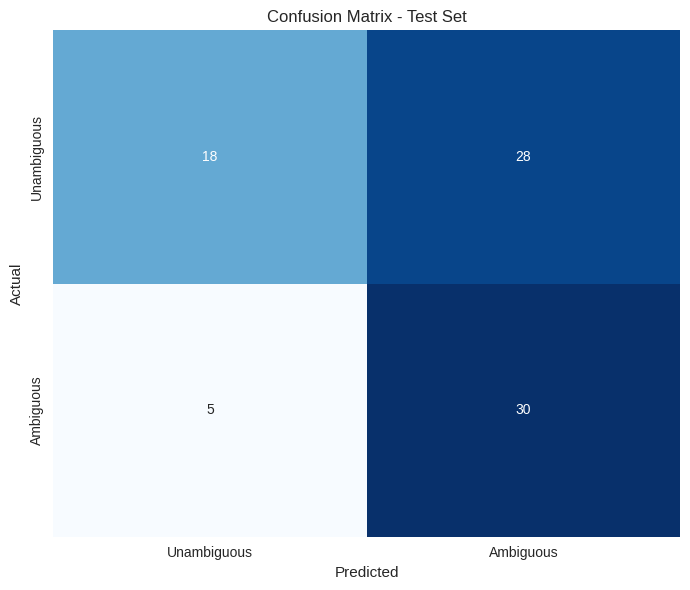


CLASSIFICATION REPORT  - Test Set
              precision    recall  f1-score   support

 Unambiguous     0.7826    0.3913    0.5217        46
   Ambiguous     0.5172    0.8571    0.6452        35

    accuracy                         0.5926        81
   macro avg     0.6499    0.6242    0.5835        81
weighted avg     0.6679    0.5926    0.5751        81



In [ ]:
# Few-shot pipeline for anaphora ambiguity detection using candidate counting with softmax thresholding
# Updated: Adds Predicate Distance features to the classifier.

import os
import re
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from transformers import AutoModel
import torch.nn.functional as F

# Optional similarity libs
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    SentenceTransformer = None
    util = None

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-large-finetuned-squadv2"
SPACY_MODEL = "en_core_web_sm"

# Ensure this points to the CSV generated by your SRL extraction script
DATA_PATH = "anaphoric_ambiguity_srl_final.csv"

BATCH_SIZE = 8
MAX_LENGTH = 512
VAL_SET_SIZE = 0.2
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

WINDOW_CHAR_HALF = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# Load spaCy
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

# -------------------------
# Load optional similarity models
# -------------------------
EMBED_MODEL = None
if SentenceTransformer is not None:
    try:
        # Lightweight embedding model
        EMBED_MODEL_NAME = "all-MiniLM-L6-v2"
        EMBED_MODEL = SentenceTransformer(EMBED_MODEL_NAME)
    except Exception as e:
        print("Warning: SentenceTransformer failed to load:", e)
        EMBED_MODEL = None

if fuzz is None:
    print("Warning: rapidfuzz not available — fuzzy matching disabled.")

# -------------------------
# Text normalization & matching utilities
# -------------------------
def normalize_text_for_match(text):
    """
    Basic normalization to improve string matching.
    """
    if text is None:
        return ""
    t = str(text).lower()
    t = re.sub(r"[^\w\s#]", " ", t)
    t = re.sub(r"\b(the|a|an)\b\s+", "", t)  # remove leading determiners
    t = " ".join(t.split())
    return t

def fuzzy_similarity(a, b):
    if fuzz is None:
        return 0.0
    try:
        return fuzz.token_set_ratio(a, b) / 100.0
    except Exception:
        return 0.0

def best_srl_match(candidate_text, current_srl_dict,
                   fuzzy_threshold=0.70, embed_threshold=0.65,
                   combined_threshold=0.75, embed_model=EMBED_MODEL):
    """
    Robust matching of candidate_text to entries in current_srl_dict.
    Returns (srl_val, pred_dist, best_score, best_key)
    """
    if not current_srl_dict:
        return 0, -1, 0.0, None

    cand_norm = normalize_text_for_match(candidate_text)

    # Quick exact normalized-key match
    for key in current_srl_dict:
        if normalize_text_for_match(key) == cand_norm:
            meta = current_srl_dict[key]
            return int(meta.get('srl_match', 0)), int(meta.get('pred_dist', -1)), 1.0, key

    best_score = 0.0
    best_key = None
    best_meta = None

    cand_emb = None
    if embed_model is not None:
        try:
            cand_emb = embed_model.encode(cand_norm, convert_to_tensor=True)
        except Exception:
            cand_emb = None

    for key, meta in current_srl_dict.items():
        key_norm = normalize_text_for_match(key)

        f_score = fuzzy_similarity(cand_norm, key_norm)

        e_score = 0.0
        if cand_emb is not None:
            try:
                key_emb = embed_model.encode(key_norm, convert_to_tensor=True)
                e_score = float(util.cos_sim(cand_emb, key_emb))
            except Exception:
                e_score = 0.0

        if (f_score > 0 and e_score > 0):
            combined = 0.5 * f_score + 0.5 * e_score
        elif f_score > 0:
            combined = f_score
        else:
            combined = e_score

        if combined > best_score:
            best_score = combined
            best_key = key
            best_meta = meta

    # Decide match based on thresholds
    if best_score >= combined_threshold or (best_score >= fuzzy_threshold and embed_model is None) or (best_score >= embed_threshold and fuzz is None):
        return int(best_meta.get('srl_match', 0)), int(best_meta.get('pred_dist', -1)), float(best_score), best_key

    return 0, -1, best_score, None

# -------------------------
# Preprocessing
# -------------------------
def preprocess_for_evaluation(df):
    print("\n" + "=" * 60)
    print("PREPROCESSING DATA (WITH SRL)")
    print("=" * 60)

    df['group_id'] = df['Id'].apply(lambda x: '-'.join(str(x).split('-')[:2]))

    # Build SRL lookup per group_id
    srl_lookup = {}
    for idx, row in df.iterrows():
        gid = row['group_id']
        cand_text = str(row['Candidate_Antecedent']).strip()

        if gid not in srl_lookup:
            srl_lookup[gid] = {}

        srl_lookup[gid][cand_text] = {
            'srl_match': int(row.get('SRL_Match', 0)),
            'pred_dist': int(row.get('Predicate_Distance', -1))
        }

    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1

        pronoun_marker = ""
        for i in range(10):
            marker = f"{pronoun}#{i}"
            if marker in context_hashed:
                pronoun_marker = marker
                break

        if pronoun_marker:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            context_clean = context_hashed.replace(pronoun_marker, pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun)
            context_clean = context_hashed

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': int(pronoun_char_start),
                'srl_data': srl_lookup.get(group_id, {})
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    if not eval_df.empty:
        print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

# -------------------------
# Candidate Extraction
# -------------------------
def _pos_based_spans(spacy_doc, max_expansion=2):
    spans = []
    toks = list(spacy_doc)

    for i, tok in enumerate(toks):
        if tok.pos_ in ("NOUN", "PROPN"):
            spans.append((tok.idx, tok.idx + len(tok.text), tok.text))
            start = i
            expansion_count = 0
            while start > 0 and expansion_count < max_expansion:
                prev_tok = toks[start - 1]
                if prev_tok.pos_ in ("DET", "ADJ", "NUM"):
                    start -= 1
                    expansion_count += 1
                else:
                    break
            if start < i:
                span = spacy_doc[start:i+1]
                spans.append((span.start_char, span.end_char, span.text))
    return spans

def extract_candidates_multi(context_slice, pronoun_rel_char):
    doc = nlp(context_slice)
    raw_candidates = []

    for nc in doc.noun_chunks:
        if nc.end_char <= pronoun_rel_char:
            raw_candidates.append((nc.start_char, nc.end_char, nc.text))

    for ent in doc.ents:
        if ent.end_char <= pronoun_rel_char:
            raw_candidates.append((ent.start_char, ent.end_char, ent.text))

    for s, e, t in _pos_based_spans(doc, max_expansion=2):
        if e <= pronoun_rel_char:
            raw_candidates.append((s, e, t))

    seen = set()
    candidates = []
    for s, e, t in raw_candidates:
        key = (int(s), int(e))
        if key in seen:
            continue
        seen.add(key)
        candidates.append({'start': int(s), 'end': int(e), 'text': t})

    if not candidates:
        nearest = None
        min_dist = None
        for tok in doc:
            if tok.pos_ in ("NOUN", "PROPN"):
                if tok.end_char <= pronoun_rel_char:
                    dist = pronoun_rel_char - tok.end_char
                    if min_dist is None or dist < min_dist:
                        min_dist = dist
                        nearest = tok

        if nearest is not None:
            candidates.append({
                'start': int(nearest.idx),
                'end': int(nearest.idx + len(nearest.text)),
                'text': nearest.text
            })
        else:
            for tok in reversed(list(doc)):
                if tok.end_char <= pronoun_rel_char:
                    if tok.pos_ not in ("DET", "ADP", "CONJ", "CCONJ", "SCONJ", "PUNCT", "SPACE", "AUX"):
                        candidates.append({
                            'start': int(tok.idx),
                            'end': int(tok.idx + len(tok.text)),
                            'text': tok.text
                        })
                        break

    return candidates

# -------------------------
# Dataset
# -------------------------
class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=MAX_LENGTH, window_half=WINDOW_CHAR_HALF):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.window_half = window_half

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        full_context = row['context_clean']
        pronoun_abs = int(row['pronoun_char_start'])
        pronoun = row['pronoun']

        start_char = max(0, pronoun_abs - self.window_half)
        end_char = min(len(full_context), pronoun_abs + self.window_half + len(pronoun))
        context_slice = full_context[start_char:end_char]
        pronoun_rel = pronoun_abs - start_char

        question = f"What is the antecedent of '{pronoun}'?"

        encoding = self.tokenizer(
            question,
            context_slice,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'offset_mapping': encoding['offset_mapping'].squeeze(0),
            'label': torch.tensor(int(row['is_ambiguous_label']), dtype=torch.long),
            'context': context_slice,
            'pronoun_char_start': torch.tensor(int(pronoun_rel), dtype=torch.long),
            'row_idx': torch.tensor(idx, dtype=torch.long)
        }

# -------------------------
# Alignment
# -------------------------
def align_span_to_token_indices(span_start, span_end, offset_mapping, token_type_ids):
    start_idx = None
    end_idx = None

    if isinstance(offset_mapping, torch.Tensor):
        offsets = offset_mapping.cpu().numpy()
    else:
        offsets = np.asarray(offset_mapping)

    token_types = token_type_ids.cpu().numpy() if isinstance(token_type_ids, torch.Tensor) else np.asarray(token_type_ids)

    for i, (off, tt) in enumerate(zip(offsets, token_types)):
        tok_start, tok_end = int(off[0]), int(off[1])
        if int(tt) != 1:
            continue
        if tok_start == 0 and tok_end == 0:
            continue
        if start_idx is None and tok_start <= span_start < tok_end:
            start_idx = i
        if start_idx is not None:
            if tok_start < span_end <= tok_end:
                end_idx = i
                break
            elif tok_start < span_end:
                end_idx = i

    if start_idx is not None and end_idx is not None and start_idx <= end_idx:
        return int(start_idx), int(end_idx)
    return None, None

# -------------------------
# Feature Extraction 
# -------------------------
def extract_features_from_candidates(model, dataloader, device, verbose=False):
    model.eval()
    model.to(device)

    all_features = []
    all_labels = []
    no_candidates_count = 0

    current_dataframe = dataloader.dataset.data

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extracting features", leave=False)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            # 1. Get the Contextual Embeddings (Last Hidden State)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            # Shape: [batch_size, seq_length, 768]
            embeddings = outputs.last_hidden_state

            for i in range(len(input_ids)):
                context_slice = batch['context'][i]
                if isinstance(context_slice, bytes):
                    context_slice = context_slice.decode('utf-8')

                pronoun_rel = int(batch['pronoun_char_start'][i].item())
                offmap = batch['offset_mapping'][i]
                tt = batch['token_type_ids'][i]

                # 2. Find the Pronoun's Vector
                # We assume the pronoun is a single token or small span.
                # We take the first token of the pronoun for simplicity, or average them.
                # Note: We need to find the token index of the pronoun relative to the BERT tokens
                p_start_idx, p_end_idx = align_span_to_token_indices(
                    pronoun_rel,
                    pronoun_rel + 1, # Identifying start token is usually enough
                    offmap, tt
                )

                if p_start_idx is None:
                    # Fallback if alignment fails
                    pronoun_vec = torch.zeros(768).to(device)
                else:
                    pronoun_vec = embeddings[i, p_start_idx, :] # Shape: [768]

                candidates = extract_candidates_multi(context_slice, pronoun_rel)

                candidate_scores = []
                candidate_srl_matches = []
                candidate_pred_dists = []

                row_idx = batch['row_idx'][i].item()
                current_srl_dict = current_dataframe.iloc[row_idx]['srl_data']

                if candidates:
                    for cand in candidates:
                        # 3. Get Candidate Vector
                        s_rel, e_rel = int(cand['start']), int(cand['end'])
                        c_start, c_end = align_span_to_token_indices(s_rel, e_rel, offmap, tt)

                        if c_start is None or c_end is None:
                            continue

                        # Average the embeddings of all tokens in the candidate span
                        # Shape: [span_len, 768] -> mean -> [768]
                        cand_vec = torch.mean(embeddings[i, c_start:c_end+1, :], dim=0)

                        # 4. Compute Cosine Similarity
                        # Result is between -1 and 1
                        similarity = F.cosine_similarity(pronoun_vec.unsqueeze(0), cand_vec.unsqueeze(0))
                        candidate_scores.append(similarity.item())

                        # SRL Logic (Same as before)
                        cand_text = cand['text']
                        srl_val, dist_val, _, _ = best_srl_match(
                            cand_text, current_srl_dict,
                            embed_model=EMBED_MODEL
                        )
                        candidate_srl_matches.append(int(srl_val))
                        candidate_pred_dists.append(int(dist_val))

                # Compute features
                if not candidate_scores:
                    no_candidates_count += 1
                    features = [0.0] * 10
                else:
                    # Convert similarities to probabilities using Softmax
                    # We scale similarity by a temperature factor (e.g., 10) to make distribution sharper
                    scores_tensor = torch.tensor(candidate_scores) * 10
                    probs = torch.softmax(scores_tensor, dim=0).numpy()

                    srl_matches = np.array(candidate_srl_matches)
                    raw_dists = np.array(candidate_pred_dists)
                    clean_dists = np.where(raw_dists == -1, 20.0, raw_dists)

                    # --- SAME FEATURE EXTRACTION LOGIC AS BEFORE ---
                    max_prob = float(np.max(probs))
                    entropy = float(-np.sum(probs * np.log(probs + 1e-10)))
                    max_entropy = np.log(len(probs)) if len(probs) > 1 else 1.0
                    normalized_entropy = entropy / (max_entropy + 1e-10)
                    num_candidates = len(probs)
                    mean_prob = float(np.mean(probs))

                    sorted_indices = np.argsort(probs)[::-1]
                    sorted_probs = probs[sorted_indices]

                    if len(sorted_probs) >= 2:
                        top2_ratio = float(sorted_probs[1] / (sorted_probs[0] + 1e-10))
                        prob_gap = float(sorted_probs[0] - sorted_probs[1])
                    else:
                        top2_ratio = 0.0
                        prob_gap = 1.0

                    top1_index = sorted_indices[0]
                    top1_has_srl = float(srl_matches[top1_index]) if top1_index < len(srl_matches) else 0.0
                    weighted_srl = float(np.sum(probs * srl_matches))
                    top1_dist = float(clean_dists[top1_index]) if top1_index < len(clean_dists) else 20.0
                    weighted_dist = float(np.sum(probs * clean_dists))

                    features = [max_prob, normalized_entropy, num_candidates, top2_ratio, mean_prob, prob_gap, top1_has_srl, weighted_srl, top1_dist, weighted_dist]

                all_features.append(features)
                all_labels.append(int(labels[i].item()))

    return np.array(all_features), np.array(all_labels)

# -------------------------
# Few-Shot Classifier
# -------------------------
def train_few_shot_classifier(train_features, train_labels, val_features, val_labels):
    print("\n" + "="*60)
    print("TRAINING FEW-SHOT CLASSIFIER (WITH BALANCING)")
    print("="*60)

    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, max_depth=5, class_weight='balanced'),
        'SVM (Linear Kernel)': SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_SEED),
        'Naive Bayes': GaussianNB(),
        'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_SEED),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
    }

    best_clf = None
    best_val_f1 = -1
    best_threshold = 0.5
    best_name = ""

    for name, clf in classifiers.items():
        clf.fit(train_features, train_labels)
        try:
            val_probs = clf.predict_proba(val_features)[:, 1]
        except Exception:
            try:
                scores = clf.decision_function(val_features)
                val_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
            except Exception:
                continue

        precisions, recalls, thresholds = precision_recall_curve(val_labels, val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        current_best_thresh = thresholds[best_idx] if len(thresholds) > 0 else 0.5
        current_best_f1 = f1_scores[best_idx]

        print(f"\n{name}:")
        print(f"  Best Threshold: {current_best_thresh:.3f}")
        print(f"  Validation F1 (Ambiguous): {current_best_f1:.4f}")

        if current_best_f1 > best_val_f1:
            best_val_f1 = current_best_f1
            best_clf = clf
            best_threshold = current_best_thresh
            best_name = name

    print(f"\nSelected Model: {best_name}")
    print(f"Optimized Threshold: {best_threshold:.3f}")

    return best_clf, best_threshold

# -------------------------
# Evaluation utils
# -------------------------
def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print(f"CLASSIFICATION REPORT {title_suffix}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Pipeline
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

    # Load and preprocess data
    raw_df = pd.read_csv(DATA_PATH)
    eval_df = preprocess_for_evaluation(raw_df)

    if eval_df.empty:
        raise ValueError("No valid pronoun instances found after preprocessing.")

    # Create 3-way split
    print("\n" + "=" * 60 + "\nSTEP 1: Creating Train/Validation/Test Split\n" + "=" * 60)

    train_val_df, test_df = train_test_split(
        eval_df,
        test_size=TEST_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=eval_df['is_ambiguous_label']
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=VAL_SET_SIZE,
        random_state=RANDOM_SEED,
        stratify=train_val_df['is_ambiguous_label']
    )

    print(f"Train Set Size:      {len(train_df)} ({len(train_df)/len(eval_df)*100:.1f}%)")
    print(f"Validation Set Size: {len(val_df)} ({len(val_df)/len(eval_df)*100:.1f}%)")
    print(f"Test Set Size:       {len(test_df)} ({len(test_df)/len(eval_df)*100:.1f}%)")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(DEVICE)

    # Create datasets
    train_dataset = AnaphoraDataset(train_df, tokenizer)
    val_dataset = AnaphoraDataset(val_df, tokenizer)
    test_dataset = AnaphoraDataset(test_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Extract features
    print("\n" + "=" * 60 + "\nSTEP 2: Extracting Features for Few-Shot Learning\n" + "=" * 60)

    print("\nProcessing train set...")
    train_features, train_labels = extract_features_from_candidates(model, train_loader, DEVICE, verbose=True)

    print("\nProcessing validation set...")
    val_features, val_labels = extract_features_from_candidates(model, val_loader, DEVICE)

    print("\nProcessing test set...")
    test_features, test_labels = extract_features_from_candidates(model, test_loader, DEVICE)

    # Train few-shot classifier
    classifier, optimal_threshold = train_few_shot_classifier(train_features, train_labels, val_features, val_labels)

    # Final evaluation
    print("\n" + "=" * 60 + "\nSTEP 3: Final Test Evaluation\n" + "=" * 60)

    # Get probabilities for test set
    try:
        test_probs = classifier.predict_proba(test_features)[:, 1]
    except Exception:
        # fallback if classifier lacks predict_proba
        scores = classifier.decision_function(test_features)
        test_probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)

    # Apply the learned threshold
    test_preds = (test_probs >= optimal_threshold).astype(int)

    plot_confusion_matrix_and_report(test_labels, test_preds, title_suffix=" - Test Set")

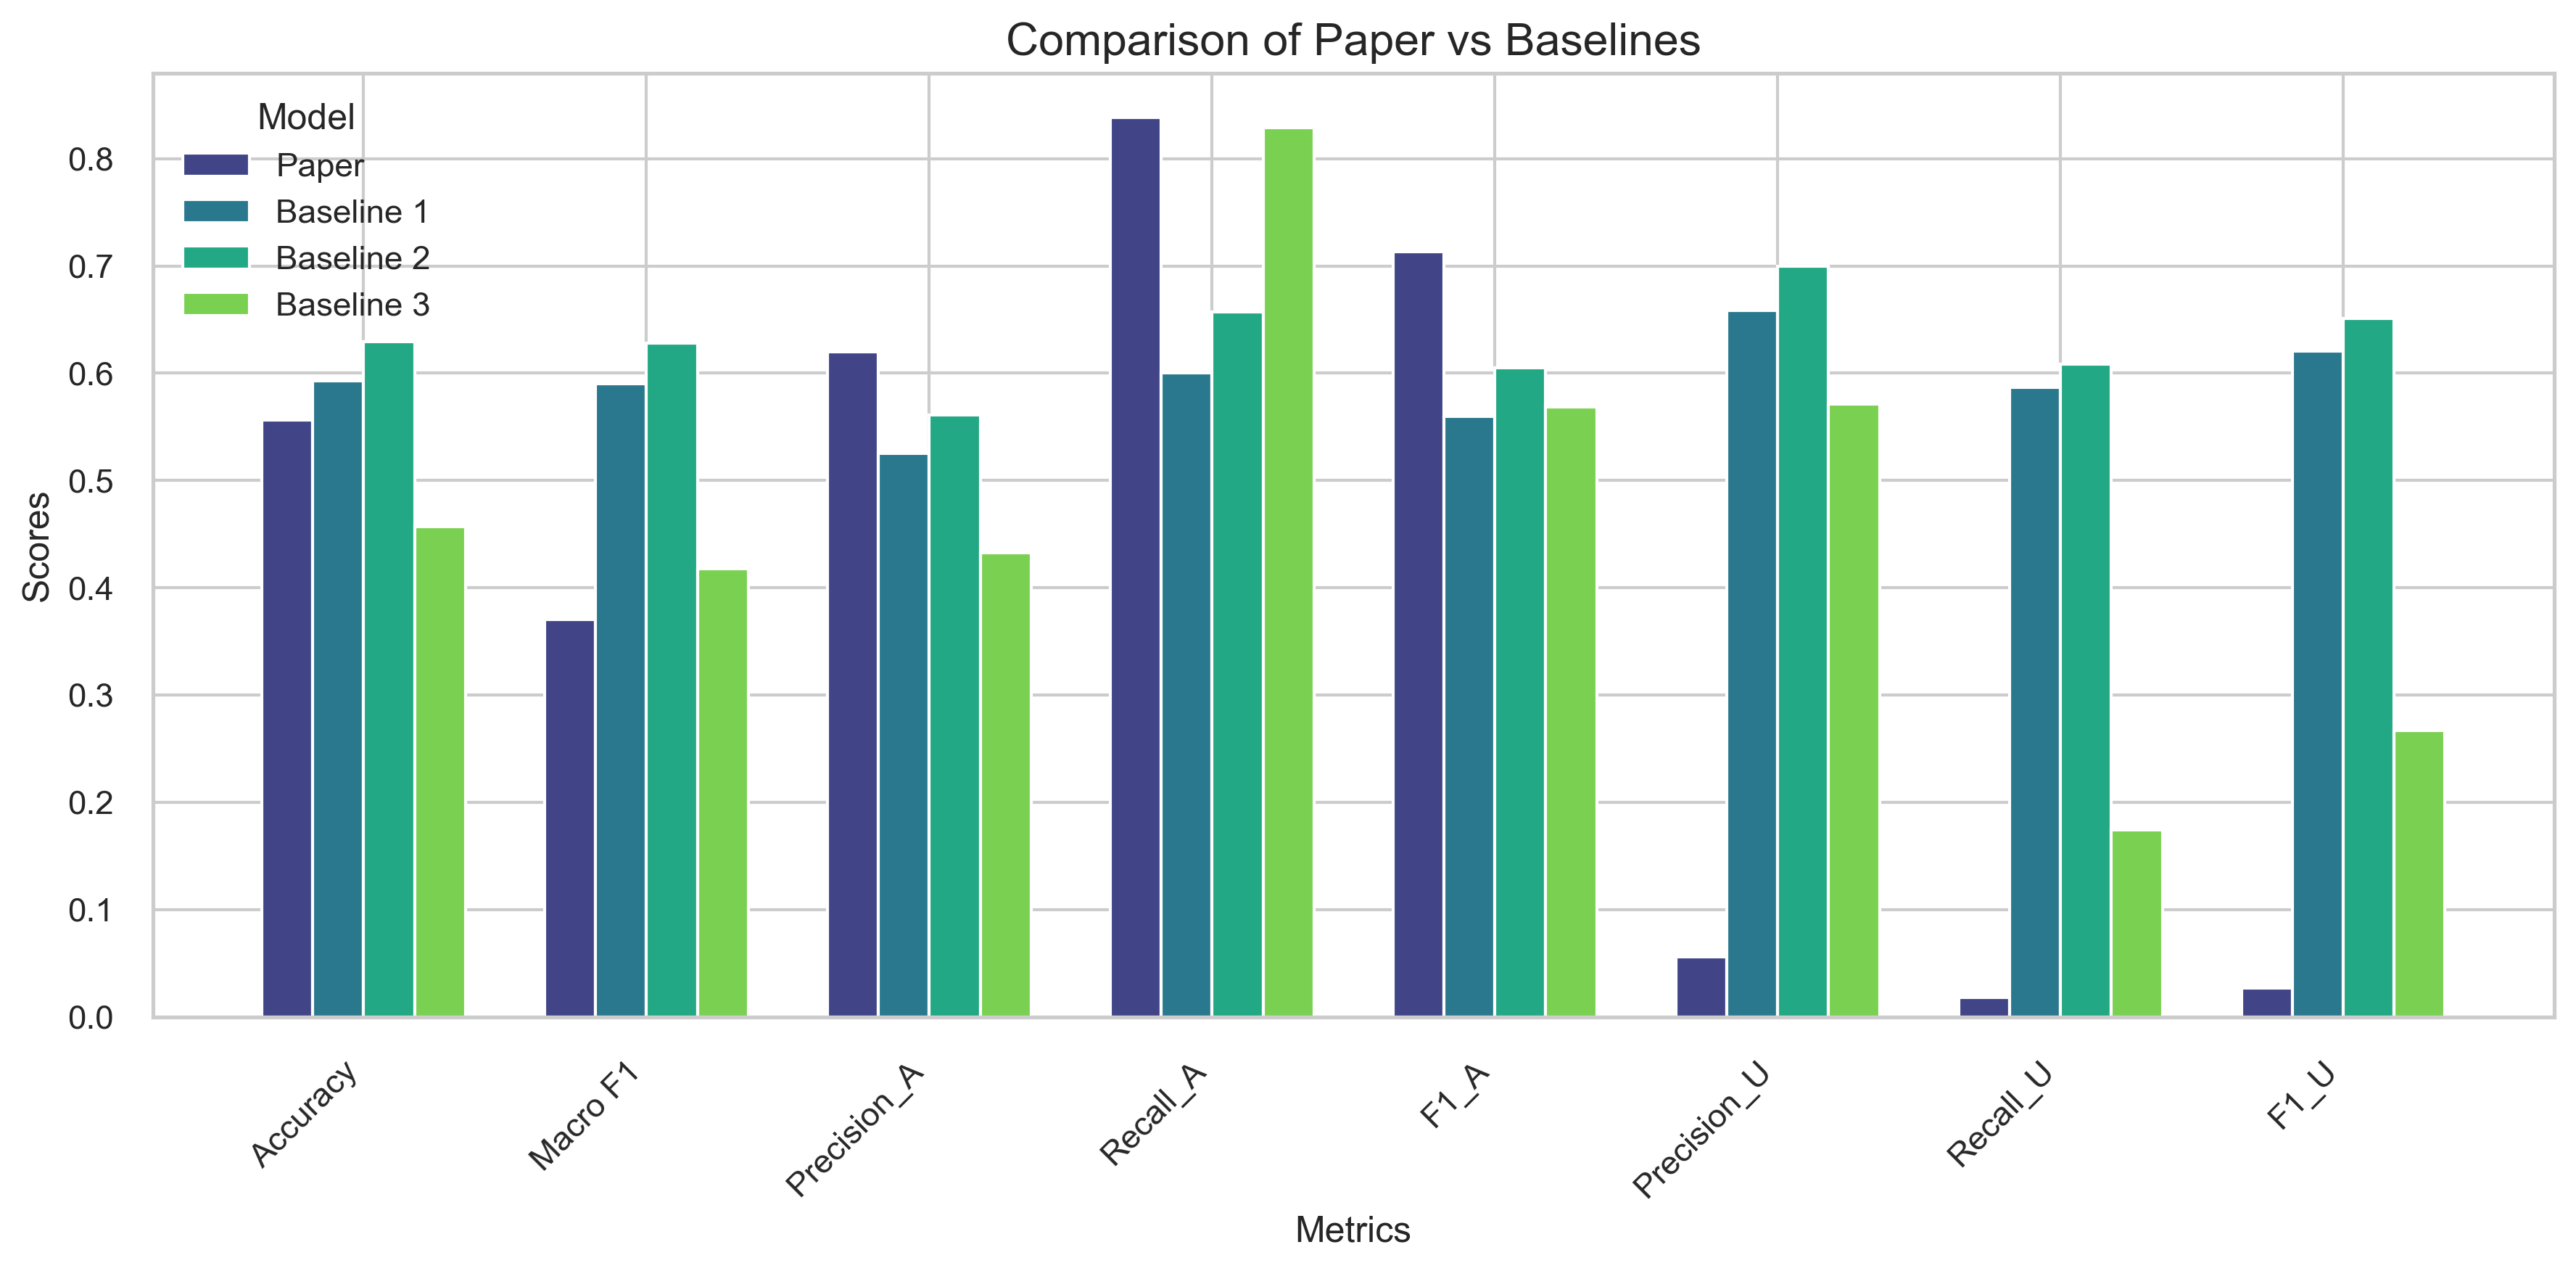

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("paper vs baseline.csv")

labels = ["Paper", "Baseline 1", "Baseline 2", "Baseline 3"]
df.index = labels

metrics = df.columns.tolist()
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(labels))

x = np.arange(len(metrics))  
width = 0.18  

fig, ax = plt.subplots(figsize=(12, 6))
for i, label in enumerate(labels):
    ax.bar(
        x + i * width,
        df.loc[label],
        width,
        label=label,
        color=palette[i]
    )

ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
ax.set_title("Comparison of Paper vs Baselines", fontsize=15)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics, rotation=45, ha="right")

ax.legend(title="Model")

plt.tight_layout()
plt.show()


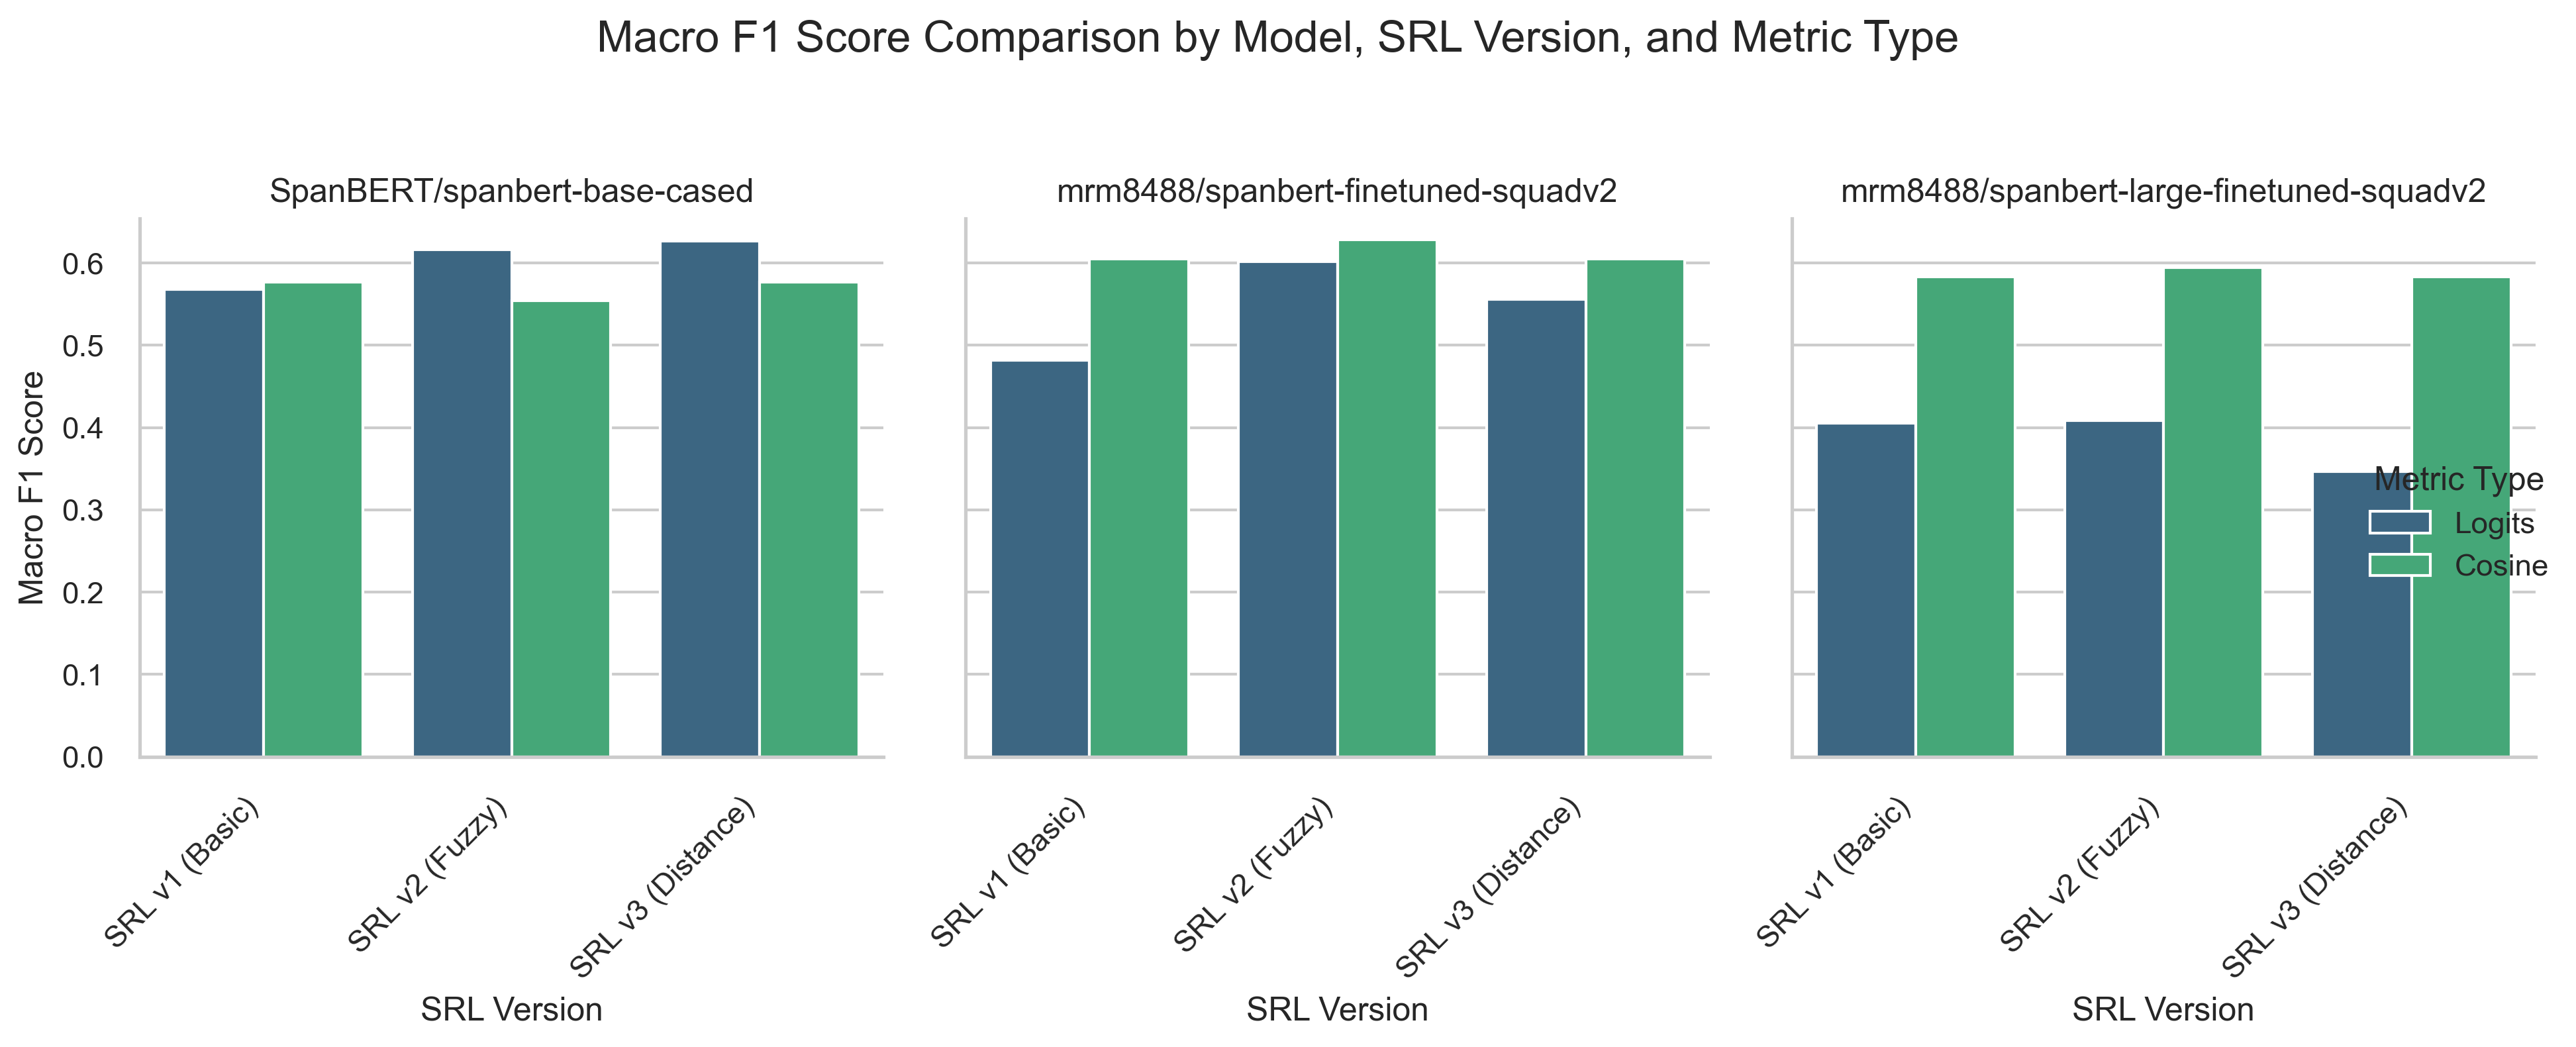

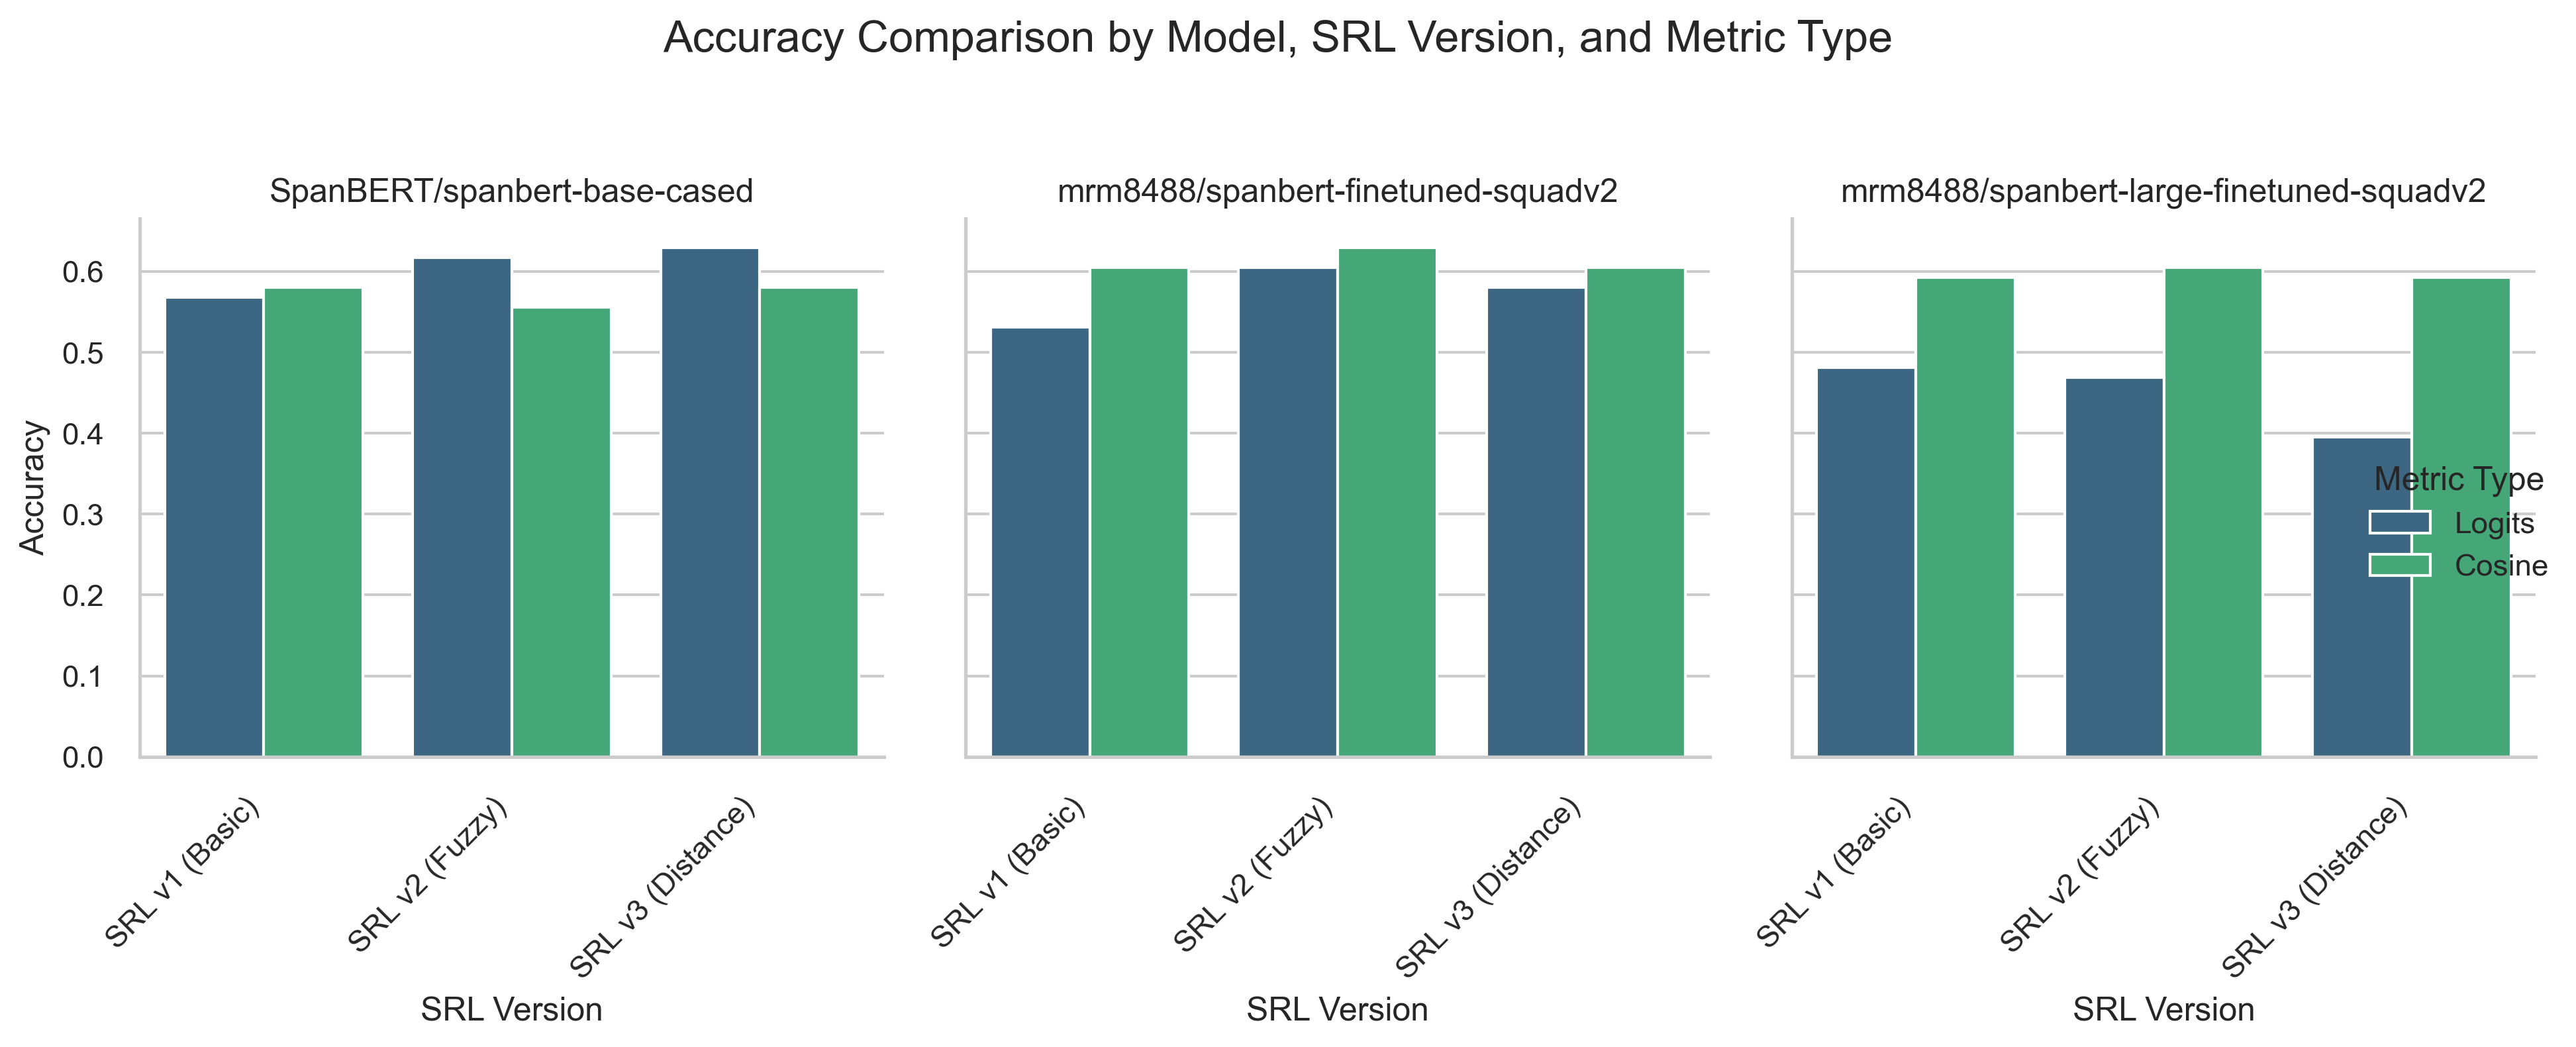

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("srl results.csv")

srl_versions = [
    "SRL v1 (Basic)",
    "SRL v2 (Fuzzy)",
    "SRL v3 (Distance)"
]
metric_types = ["QA Logits"] * 3 + ["Cosine"] * 3
models = [
    "SpanBERT/spanbert-base-cased",
    "mrm8488/spanbert-finetuned-squadv2",
    "mrm8488/spanbert-large-finetuned-squadv2"
]

num_rows = len(df)
model_list, metric_type_list, srl_version_list = [], [], []

for i in range(len(models)):
    current_model = models[i]
    for j in range(len(metric_types)):
        model_list.append(current_model)
        metric_type_list.append(metric_types[j])
        srl_version_list.append(srl_versions[j % 3])

model_list = model_list[:num_rows]
metric_type_list = metric_type_list[:num_rows]
srl_version_list = srl_version_list[:num_rows]

df["Model"] = model_list
df["Metric Type"] = [mt.replace("QA Logits", "Logits") for mt in metric_type_list]
df["SRL Version"] = srl_version_list

srl_version_order = [
    "SRL v1 (Basic)",
    "SRL v2 (Fuzzy)",
    "SRL v3 (Distance)"
]

sns.set(style="whitegrid")
def make_plot(metric_column, title_suffix):
    g = sns.catplot(
        data=df,
        x="SRL Version",
        y=metric_column,
        hue="Metric Type",
        col="Model",
        kind="bar",
        height=5,
        aspect=0.8,
        col_wrap=3,
        order=srl_version_order,
        palette="viridis",
        errorbar=None,
        legend_out=True
    )

    g.fig.suptitle(
        f"{title_suffix} Comparison by Model, SRL Version, and Metric Type",
        y=1.05,
        fontsize=16
    )

    for ax in g.axes.flat:
        ax.set_title(ax.get_title().replace("Model = ", ""), fontsize=12)
        data_max = df[df["Model"] == ax.get_title().replace("", "")][metric_column].max()
        ax.set_ylim(0, data_max * 1.1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    g.set_axis_labels("SRL Version", title_suffix)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)


make_plot("Macro F1", "Macro F1 Score")
make_plot("Accuracy", "Accuracy")

plt.show()


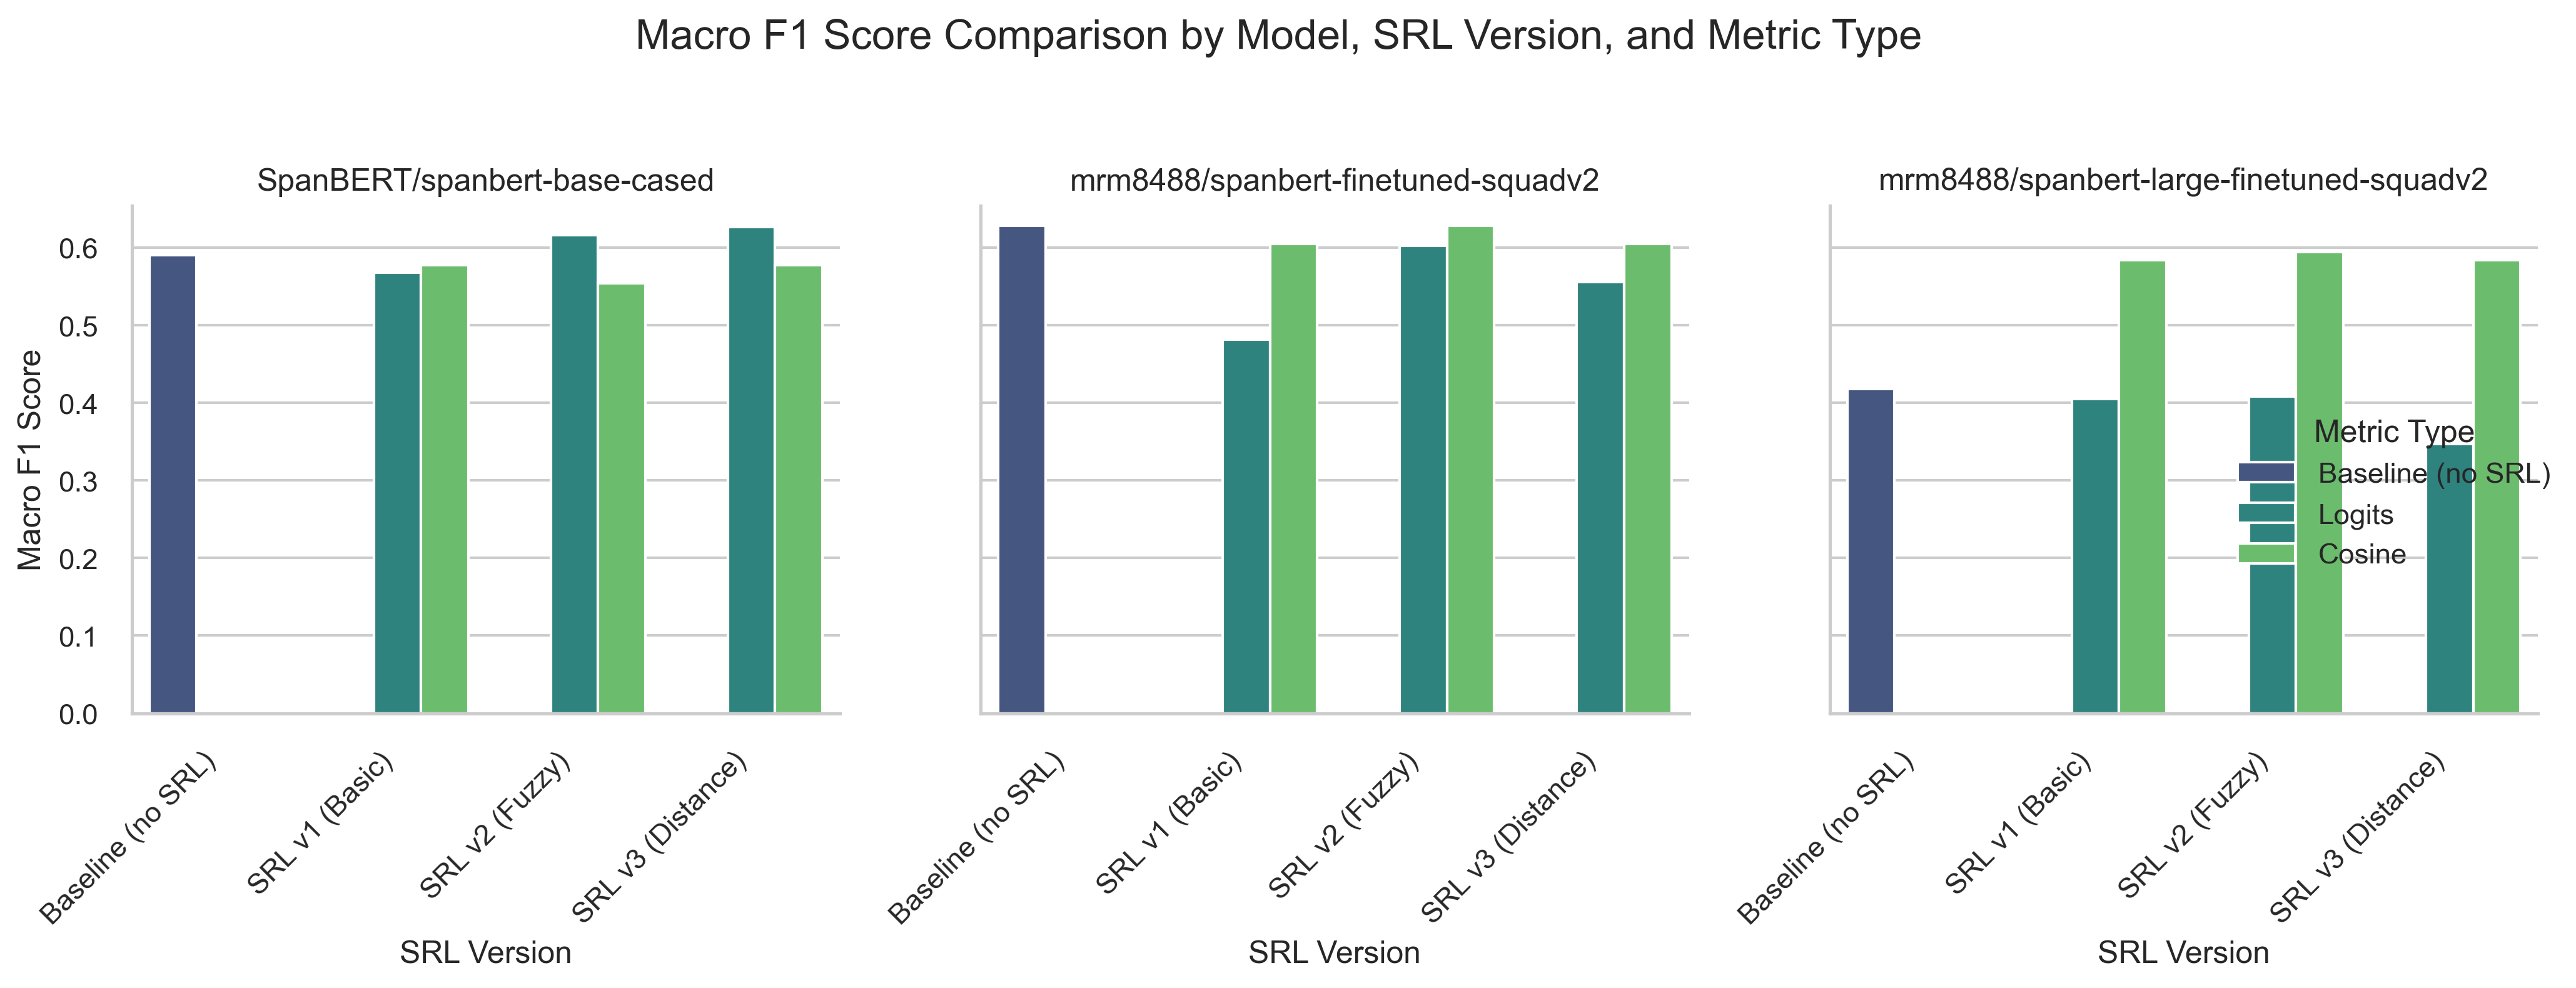

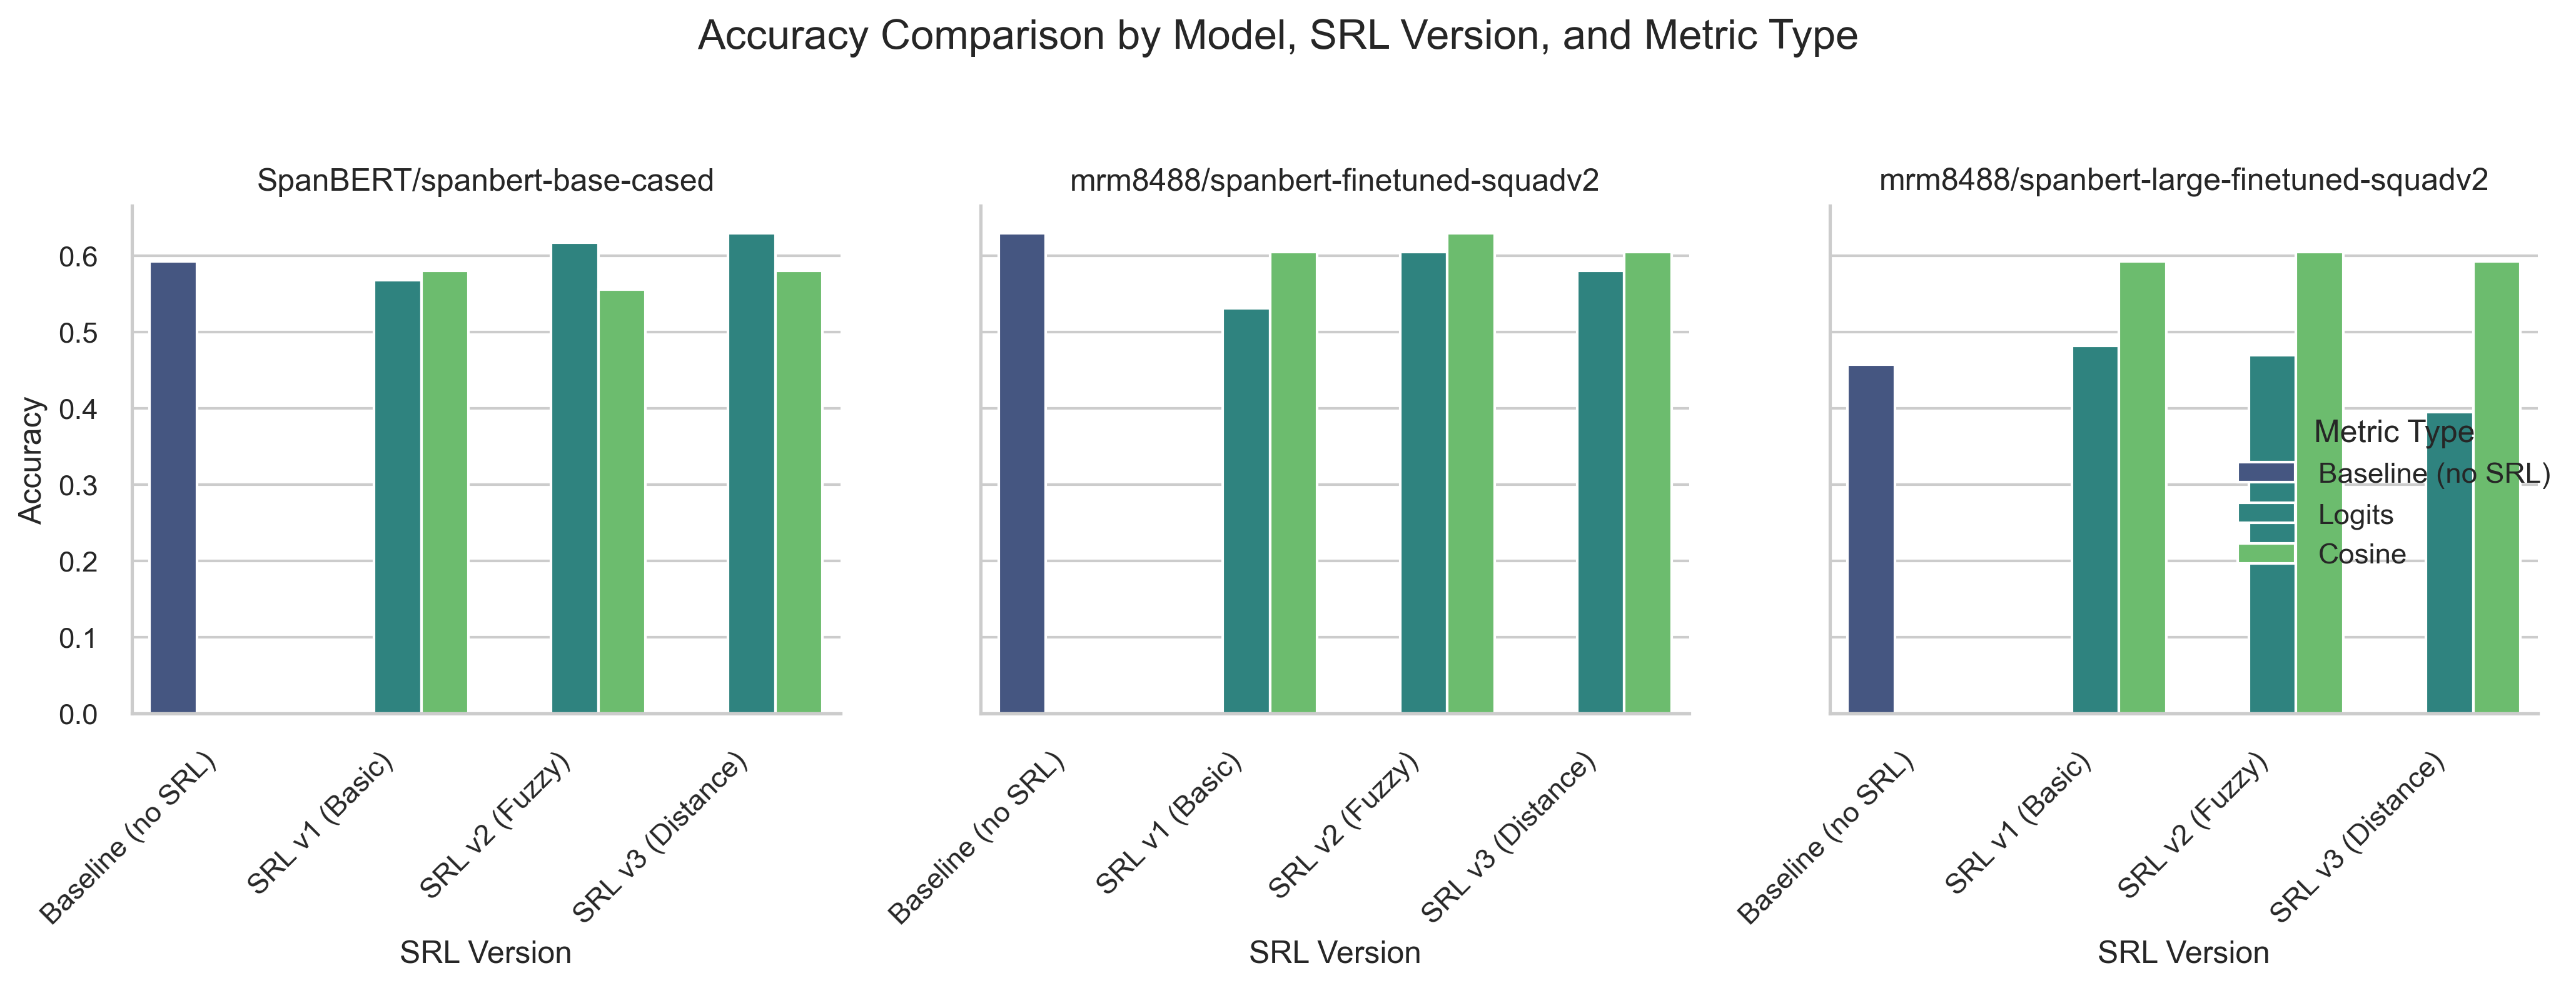

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV
# NOTE: This code assumes the file has 3 blocks of 7 rows each (21 rows total),
# where the first row of each block is the Baseline, and the subsequent 6 rows
# are the Logits/Cosine metrics for v1, v2, v3.
# The current 18-row file will still be processed, but the labels for the last 3 rows will be incorrect.
df = pd.read_csv("combined.csv")

# --- Data Structuring (Corrected for Baseline ADDED) ---

models = [
    "SpanBERT/spanbert-base-cased",
    "mrm8488/spanbert-finetuned-squadv2",
    "mrm8488/spanbert-large-finetuned-squadv2"
]

# Full 6-row pattern for Metric/SRL, including all v1/v2/v3 combinations
srl_versions_metrics_full = [
    ("Logits", "SRL v1 (Basic)"),
    ("Logits", "SRL v2 (Fuzzy)"),
    ("Logits", "SRL v3 (Distance)"),
    ("Cosine", "SRL v1 (Basic)"),
    ("Cosine", "SRL v2 (Fuzzy)"),
    ("Cosine", "SRL v3 (Distance)"),
]

num_rows = len(df)
model_list, metric_type_list, srl_version_list = [], [], []

for current_model in models:
    # 1. Add Baseline row (The intended 7th row)
    model_list.append(current_model)
    metric_type_list.append("Baseline (no SRL)")
    srl_version_list.append("Baseline (no SRL)")
    
    # 2. Add the 6 Metric/SRL rows
    for metric_type, srl_version in srl_versions_metrics_full:
        model_list.append(current_model)
        metric_type_list.append(metric_type)
        srl_version_list.append(srl_version)

# Assign the new categorical columns to the DataFrame, slicing to fit the actual row count
df["Model"] = model_list[:num_rows]
df["Metric Type"] = metric_type_list[:num_rows]
df["SRL Version"] = srl_version_list[:num_rows]

# Define the full order for the x-axis, including Baseline
srl_version_order = [
    "Baseline (no SRL)",
    "SRL v1 (Basic)",
    "SRL v2 (Fuzzy)",
    "SRL v3 (Distance)"
]

sns.set(style="whitegrid")
def make_plot(metric_column, title_suffix):
    g = sns.catplot(
        data=df,
        x="SRL Version",
        y=metric_column,
        hue="Metric Type",
        col="Model",
        kind="bar",
        height=5,
        aspect=0.8,
        col_wrap=3,
        order=srl_version_order,
        palette="viridis",
        errorbar=None,
        legend_out=True
    )

    g.fig.suptitle(
        f"{title_suffix} Comparison by Model, SRL Version, and Metric Type",
        y=1.05,
        fontsize=16
    )

    for ax in g.axes.flat:
        ax.set_title(ax.get_title().replace("Model = ", ""), fontsize=12)
        data_max = df[df["Model"] == ax.get_title().replace("", "")][metric_column].max()
        ax.set_ylim(0, data_max * 1.1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    g.set_axis_labels("SRL Version", title_suffix)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)


make_plot("Macro F1", "Macro F1 Score")
make_plot("Accuracy", "Accuracy")

plt.show()
